# **Importing libraries and data**

In [1]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sklearn

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from yellowbrick.regressor import ResidualsPlot
from sklearn import linear_model
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button style="color:"black";right:75%;" onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################
####### Load ADS using name and path

load_ads = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/DPL_Master_dataset_v2_2014-2020.csv')
load_ads = load_ads[load_ads['Nearest_service_center'] == 'DSB']
event_ = load_ads['EVENT']
load_ads = load_ads.drop(columns = ['OUTAGE_ID', 'CIRCUIT', 'DEVICE', 'TIME_OF_FIRST_CALL','STATUS','LATITUDE','LONGITUDE',
                                   'CUSTSTILLOUT','STORM_TYPE','DATE','EVENT','Resource_count_at_First_call','Resource_count_non_DPL',
                                    'Crew_lead_count','radSolarMin','DEVICESIZE','Offical_storm','Nearest_service_center'])

display(load_ads.head())

,PHASE_A,PHASE_B,PHASE_C,PHASE_T,LFS_CUSTS,MED_CUSTS,EMR_CUSTS,UTL_CUSTS,MAJ_CUSTS,GOV_CUSTS,LRT_CUSTS,WIREDOWN_PTH,WIREDOWN_PTP,TREEONWIRE_PTH,TREEONWIRE_PTP,BROKENPOLE,FIREEXPLOSION,DAMAGEDTRANS,PRIORITY,CONFIDENCE,TTR,MAJOR,TORD_False,TORD_True,ACCOUNT_TYPE_COM,ACCOUNT_TYPE_CUS,ACCOUNT_TYPE_GOV,ACCOUNT_TYPE_IND,ACCOUNT_TYPE_RES,Day_flag,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OTG,weekday,Weekend_flag,Marker_Location,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Min_Distance_service_Center,cldCvrMin,cldCvrAvg,cldCvrMax,dewPtMin,dewPtAvg,dewPtMax,feelsLikeMin,feelsLikeAvg,feelsLikeMax,heatIndexMin,heatIndexAvg,heatIndexMax,mslPresMin,mslPresAvg,mslPresMax,precip,radSolarAvg,radSolarMax,radSolarTot,relHumMin,relHumAvg,relHumMax,sfcPresMin,sfcPresAvg,sfcPresMax,snowfall,spcHumMin,spcHumAvg,spcHumMax,tempMin,tempAvg,tempMax,windChillMin,windChillAvg,windChillMax,windDirAvg,windDir80mAvg,windDir100mAvg,windSpdMin,windSpdAvg,windSpdMax,windSpd80mMin,windSpd80mAvg,windSpd80mMax,windSpd100mMin,windSpd100mAvg,windSpd100mMax,wetBulbMin,wetBulbAvg,wetBulbMax,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,DEVICETYPE,TOPFUSE,TOTCUST_A,TOTCUST_B,TOTCUST_C,TOTCUST_T,VOLTAGE,UNDERGD,NORMALLYOPEN,TOTKVA_A,TOTKVA_B,TOTKVA_C,Total_Crew_dispatched,Total_Crew_available,Line_crew,Service_crew,Substation_crew,Network_crew,Contractor,rank,rank_cd,Total_cust
2,False,True,False,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,H,121.50,0.0,23.0,0.0,False,False,False,False,False,False,0.000000,1.000000,3.0,Wednesday,False,Marker 26,2,2,2,2,2,2,2,2,2,4,4.162488,1.0,78.0,99.0,17.8,24.2,30.1,16.5,27.2,41.2,21.7,30.7,41.8,1018.2,1022.9,1027.0,0.00,82.0,381.0,1969.0,59.0,77.0,87.0,984.2,988.1,992.0,0.00,2.1,2.8,3.6,21.7,30.7,41.8,16.5,27.2,41.2,135.0,193.0,193.0,0.7,3.9,7.7,2.2,6.8,12.3,2.2,6.7,12.2,20.6,28.4,37.2,20.1,7.0,7.8,98.0,28.0,1.474576,1.007925,FUSE,False,0.0,312.0,0.0,0.0,12KV (95%),False,False,0.0,1415.0,0.0,0,9,8,1,0,0,0,1.0,1.0,1.0
8,False,False,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,H,188.60,0.0,1.0,0.0,False,False,False,False,True,True,0.500000,-0.866025,9.0,Wednesday,False,Marker 21,0,1,4,4,4,4,5,5,5,5,11.269541,0.0,75.0,98.0,17.9,24.4,29.0,15.4,27.3,41.1,20.7,30.9,41.2,1018.0,1022.9,1027.1,0.00,83.5,390.3,2003.6,58.7,77.7,95.4,982.8,987.5,991.6,0.00,2.1,2.9,3.4,20.7,30.9,41.2,15.4,27.3,41.1,137.0,201.0,201.0,0.9,3.9,7.4,1.9,7.9,12.6,1.9,7.8,12.5,19.9,28.6,36.4,20.5,6.5,8.8,98.0,36.7,1.625213,1.008954,FUSE,False,0.0,0.0,14.0,0.0,12KV (100%),False,False,0.0,0.0,100.0,1,14,13,1,0,0,0,1.0,2.0,0.0
9,True,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,H,55.90,0.0,5.0,0.0,False,False,False,False,False,True,0.500000,-0.866025,10.0,Wednesday,False,Marker 25,1,2,5,5,5,5,6,6,6,6,11.595286,0.0,77.0,99.0,17.7,24.4,29.2,15.8,27.9,41.9,20.7,31.3,42.1,1018.0,1022.8,1027.0,0.00,82.5,390.3,1979.7,57.4,76.7,96.7,985.5,990.0,994.2,0.00,2.1,2.9,3.5,20.7,31.3,42.1,15.8,27.9,41.9,154.0,201.0,201.0,0.9,3.9,7.7,1.7,7.7,12.5,1.7,7.6,12.4,19.9,28.8,37.1,21.4,6.8,8.7,99.0,39.3,1.684669,1.008828,FUSE,False,16.0,1.0,0.0,0.0,12KV (100%),False,False,75.0,0.0,0.0,1,14,13,1,0,0,0,2.0,1.0,0.0
27,False,False,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,H,142.25,0.0,1.0,0.0,False,False,False,False,True,False,-0.866025,0.500000,14.0,Thursday,False,Marker 25,0,2,2,4,4,5,7,9,9,11,15.183077,99.0,100.0,100.0,2.8,17.9,28.5,-7.6,10.1,27.1,8.1,21.1,30.7,1012.3,1016.8,1025.9,0.05,37.9,180.0,910.0,75.0,87.0,100.0,979.7,984.2,993.0,1.36,1.1,2.3,3.4,8.1,21.1,30.7,-7.6,10.1,27.1,359.0,2.0,2.0,3.4,10.8,17.3,3.6,15.6,24.3,3.6,15.4,24.0,7.2,20.3,29.5,22.6,13.9,13.3,1.0,25.0,1.333333,1.013576,FUSE,False,18.0,0.0,0.0,0.0,12KV (100%),False,False

In [3]:
######################################################################## ALL USER DEFINED FUNCTION ARE LOGGED HERE #############################################################################
################################################################################################################################################################################################

# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# get names of all categorical data present in data
def get_index_of_categorical_columns(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))


def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

def segment(x):
    if(x<=120):
        return "0-120"
    elif(x<=240):
        return "120-240"
    elif(x<=360):
        return "240-360"
    elif(x<=480):
        return "360-480"
    elif(x<=600):
        return "480-600"
    elif(x<=720):
        return "600-720"
    else:
        return ">720"
    
def segment_storm(x):
    if(x<=120):
        return "0-120"
    elif(x<=240):
        return "120-240"
    elif(x<=360):
        return "240-360"
    elif(x<=480):
        return "360-480"
    elif(x<=600):
        return "480-600"
    elif(x<=720):
        return "600-720"
    elif(x<=840):
        return "720-840"
    elif(x<=960):
        return "840-960"
    elif(x<=1080):
        return "960-1080"
    elif(x<=1200):
        return "1080-1200"
    elif(x<=1320):
        return "1200-1320"
    elif(x<=1440):
        return "1200-1440"
    else:
        return ">1440"
    
def style_diag(data):
    diag_mask = pd.DataFrame("", index=data.index, columns=data.columns)
    min_axis = min(diag_mask.shape)
    diag_mask.iloc[range(min_axis), range(min_axis)] = 'background-color:#aed581'
    return diag_mask

def customer_metrics(y_test,y_test_pred):
    df_pred = pd.DataFrame(data={'actualRaw': y_test, 'predictedRaw': y_test_pred})
    df_pred['Actual_segment'] = df_pred['actualRaw'].apply(segment)
    df_pred['Prediction_segment'] = df_pred['predictedRaw'].apply(segment)
    business_KPI = df_pred[['Actual_segment','Prediction_segment']]

    #conversion to percentage
    business_KPI = pd.pivot_table(business_KPI, index='Actual_segment',columns=['Prediction_segment'], values='Actual_segment', aggfunc=lambda x: len(x))
    business_KPI["total"] =  business_KPI.sum(axis=1)
    business_KPI.columns.name = 'Predicted_Values'
    business_KPI.index.name = 'Actual_Values'

    # Add the grand total row, summing all values in a column
    business_KPI.loc['total', :] = business_KPI.sum()
    business_KPI = business_KPI.round(0)
    return business_KPI

def customer_metrics_storm(y_test,y_test_pred):
    df_pred = pd.DataFrame(data={'actualRaw': y_test, 'predictedRaw': y_test_pred})
    df_pred['Actual_segment'] = df_pred['actualRaw'].apply(segment_storm)
    df_pred['Prediction_segment'] = df_pred['predictedRaw'].apply(segment_storm)
    business_KPI = df_pred[['Actual_segment','Prediction_segment']]

    #conversion to percentage
    business_KPI = pd.pivot_table(business_KPI, index='Actual_segment',columns=['Prediction_segment'], values='Actual_segment', aggfunc=lambda x: len(x))
    business_KPI["total"] =  business_KPI.sum(axis=1)
    business_KPI.columns.name = 'Predicted_Values'
    business_KPI.index.name = 'Actual_Values'

    # Add the grand total row, summing all values in a column
    business_KPI.loc['total', :] = business_KPI.sum()
    business_KPI = business_KPI.round(0)
    return business_KPI

# Preprocessing Data 

## Columns with Categorical Values

In [4]:
object_columns = load_ads.loc[:, (load_ads.dtypes == object) | (load_ads.dtypes == bool)]
print(list(object_columns.columns))

['PHASE_A', 'PHASE_B', 'PHASE_C', 'PHASE_T', 'WIREDOWN_PTH', 'WIREDOWN_PTP', 'TREEONWIRE_PTH', 'TREEONWIRE_PTP', 'BROKENPOLE', 'FIREEXPLOSION', 'DAMAGEDTRANS', 'PRIORITY', 'CONFIDENCE', 'ACCOUNT_TYPE_COM', 'ACCOUNT_TYPE_CUS', 'ACCOUNT_TYPE_GOV', 'ACCOUNT_TYPE_IND', 'ACCOUNT_TYPE_RES', 'Day_flag', 'weekday', 'Weekend_flag', 'Marker_Location', 'DEVICETYPE', 'TOPFUSE', 'VOLTAGE', 'UNDERGD', 'NORMALLYOPEN']


## Dummifying Categorical Variables

In [5]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
################################################################################################################################################################################################

ads = load_ads[:]

ads = pd.get_dummies(ads, columns=['WIREDOWN_PTH', 'WIREDOWN_PTP', 'TREEONWIRE_PTH', 'TREEONWIRE_PTP', 'BROKENPOLE', 
                                   'FIREEXPLOSION', 'DAMAGEDTRANS','PRIORITY', 'CONFIDENCE', 'ACCOUNT_TYPE_COM', 
                                   'ACCOUNT_TYPE_CUS', 'ACCOUNT_TYPE_GOV', 'ACCOUNT_TYPE_IND', 'ACCOUNT_TYPE_RES', 
                                   'Day_flag', 'weekday', 'Weekend_flag', 'DEVICETYPE', 'Marker_Location',
                                   'TOPFUSE', 'UNDERGD', 'NORMALLYOPEN','VOLTAGE'])

## Printing all the columns after dummifying

In [6]:
# print list of columns present in the ads and drop na's from the dataset
print(list(ads.columns))
ads.dropna(inplace=True)
print(ads.shape)

['PHASE_A', 'PHASE_B', 'PHASE_C', 'PHASE_T', 'LFS_CUSTS', 'MED_CUSTS', 'EMR_CUSTS', 'UTL_CUSTS', 'MAJ_CUSTS', 'GOV_CUSTS', 'LRT_CUSTS', 'TTR', 'MAJOR', 'TORD_False', 'TORD_True', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OTG', 'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr', 'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Min_Distance_service_Center', 'cldCvrMin', 'cldCvrAvg', 'cldCvrMax', 'dewPtMin', 'dewPtAvg', 'dewPtMax', 'feelsLikeMin', 'feelsLikeAvg', 'feelsLikeMax', 'heatIndexMin', 'heatIndexAvg', 'heatIndexMax', 'mslPresMin', 'mslPresAvg', 'mslPresMax', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumMin', 'relHumAvg', 'relHumMax', 'sfcPresMin', 'sfcPresAvg', 'sfcPresMax', 'snowfall', 'spcHumMin', 'spcHumAvg', 'spcHumMax', 'tempMin', 'tempAvg', 'tempMax', 'windChillMin', 'windChillAvg', 'windChillMax', 'windDirAvg', 'windDir80mAvg', 

# Distribution and transformation of Y-variable

## Target Variable Analysis: Is it Normal?

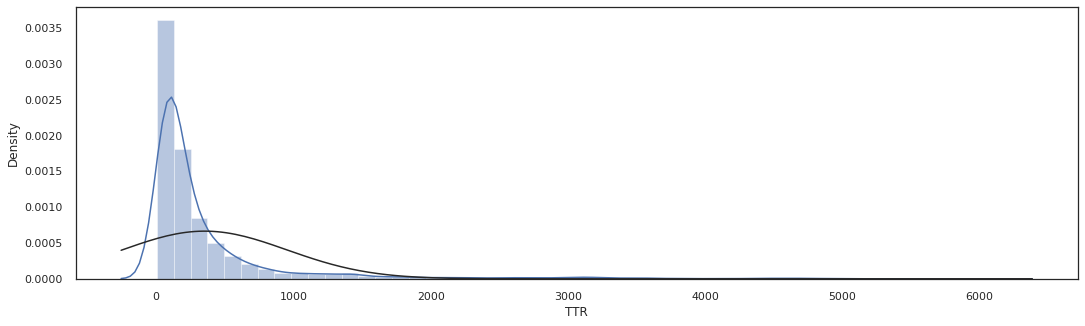

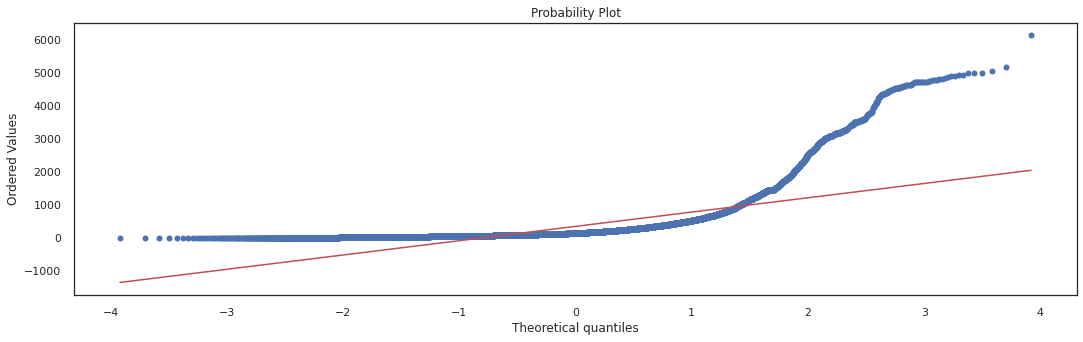

In [7]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,5)})
sns.set_style("white")

sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()
res = stats.probplot(ads['TTR'], plot=plt)

#### **Log Transformation of Tanget Variable (TTR)**

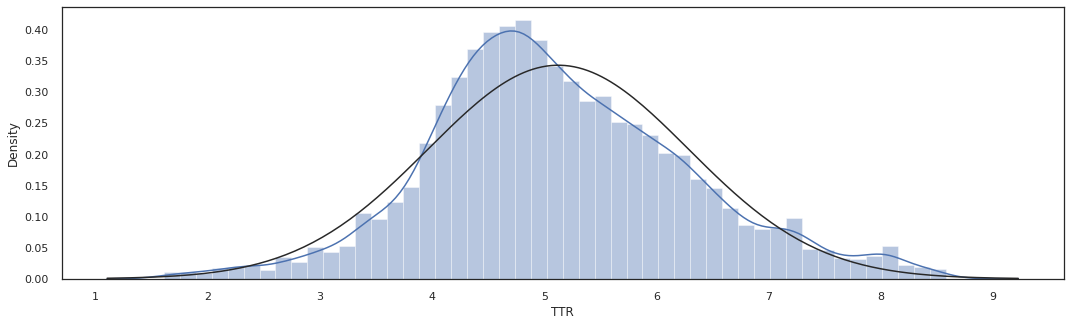

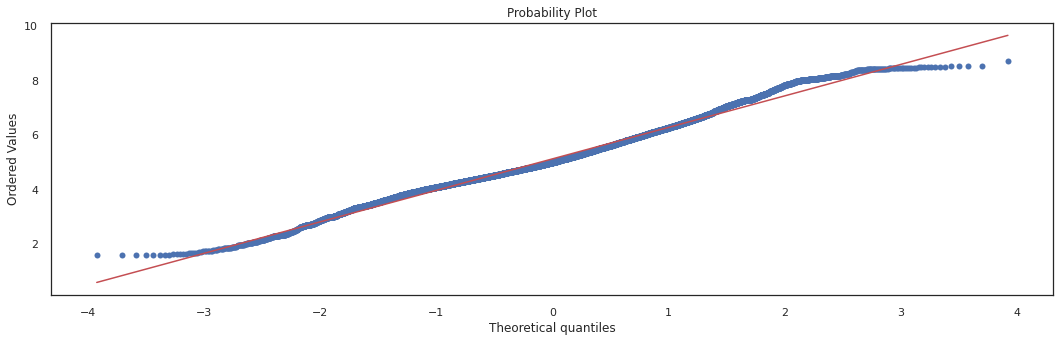

In [8]:
# Apply log e tranformation to the dataset
ads['TTR'] = np.log(ads['TTR'])
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,5)})
sns.set_style("white")

sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()
res = stats.probplot(ads['TTR'], plot=plt)

# Feature Selection using different Models

In [9]:
%%time

#########################################################################################################################################################################################################
######################################################################## FEATURE SELECTION : MAX VOTING REGIME ##########################################################################################

X = ads.drop(['TTR'],axis=1)
y = ads['TTR']

ols = LinearRegression()
ols.fit(X.values, y.values)
pls = PLSRegression(n_components=15)
pls.fit(X.values, y.values)
rf = RandomForestRegressor(n_estimators=150, n_jobs = -1)
rf.fit(X,y)
xg = xgb.XGBRegressor(n_jobs=-1, max_depth=15)
xg.fit(X,y)

CPU times: user 5min 35s, sys: 3.21 s, total: 5min 38s
Wall time: 2min 7s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
ols_reg = pd.DataFrame({'Features': X.columns, 'Importance_Score_ols': ols.coef_}).sort_values(by='Importance_Score_ols',ascending=False)
pls_reg = pd.DataFrame({'Features': X.columns, 'Importance_Score_PLS': pls.coef_.ravel()}).sort_values(by='Importance_Score_PLS',ascending=False)
rftrees = pd.DataFrame({'Features': X.columns, 'Importance_Score_Random_Forest': rf.feature_importances_}).sort_values(by='Importance_Score_Random_Forest',ascending=False)
xgboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_XGBoost': xg.feature_importances_}).sort_values(by='Importance_Score_XGBoost',ascending=False)


ols_reg.reset_index(drop=True,inplace=True)
pls_reg.reset_index(drop=True,inplace=True)
rftrees.reset_index(drop=True,inplace=True)
xgboost.reset_index(drop=True,inplace=True)

ols_reg = ols_reg.head(20)
pls_reg = pls_reg.head(20)
rftrees = rftrees.head(20)
xgboost = xgboost.head(20)

## **Feature Importance using Ordinary Least Square**

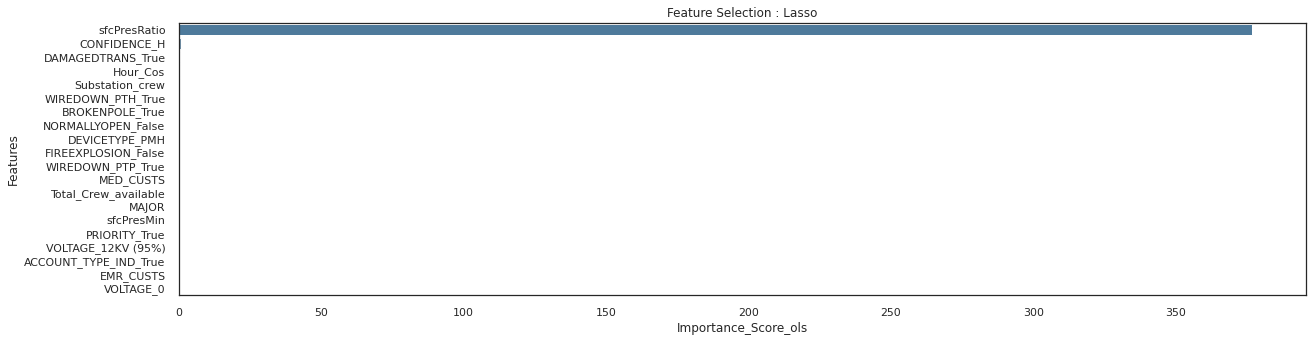

In [11]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_ols", y="Features", data=ols_reg, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : Lasso')

In [12]:
display(ols_reg)

,Features,Importance_Score_ols
0,sfcPresRatio,376.810754
1,CONFIDENCE_H,0.915614
2,DAMAGEDTRANS_True,0.513627
3,Hour_Cos,0.414335
4,Substation_crew,0.401993
5,WIREDOWN_PTH_True,0.272006
6,BROKENPOLE_True,0.247222
7,NORMALLYOPEN_False,0.227380
8,DEVICETYPE_PMH,0.221254
9,FIREEXPLOSION_False,0.185352


## **Feature Importance using Partial Least Square**

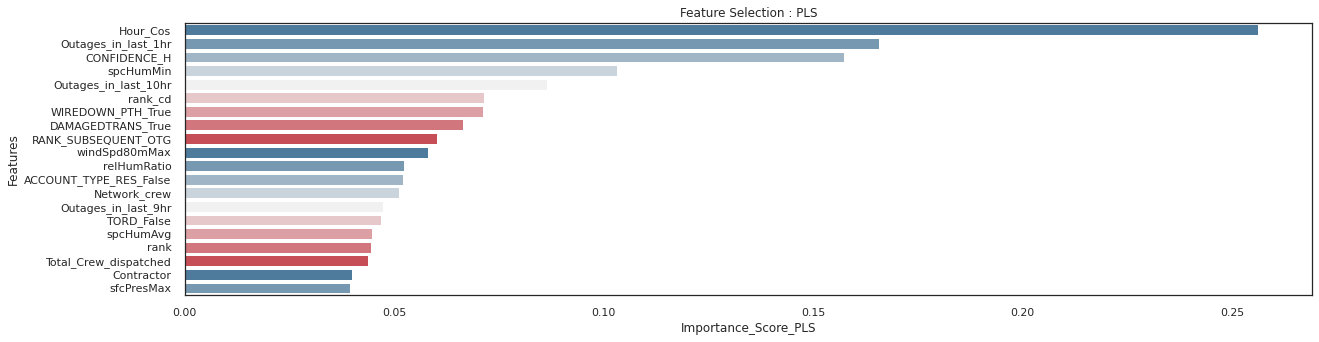

In [13]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_PLS", y="Features", data=pls_reg , palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : PLS')

In [14]:
display(pls_reg)

,Features,Importance_Score_PLS
0,Hour_Cos,0.256274
1,Outages_in_last_1hr,0.165690
2,CONFIDENCE_H,0.157483
3,spcHumMin,0.103234
4,Outages_in_last_10hr,0.086507
5,rank_cd,0.071364
6,WIREDOWN_PTH_True,0.071105
7,DAMAGEDTRANS_True,0.066375
8,RANK_SUBSEQUENT_OTG,0.060187
9,windSpd80mMax,0.058015


## **Feature Importance using Random Forest**

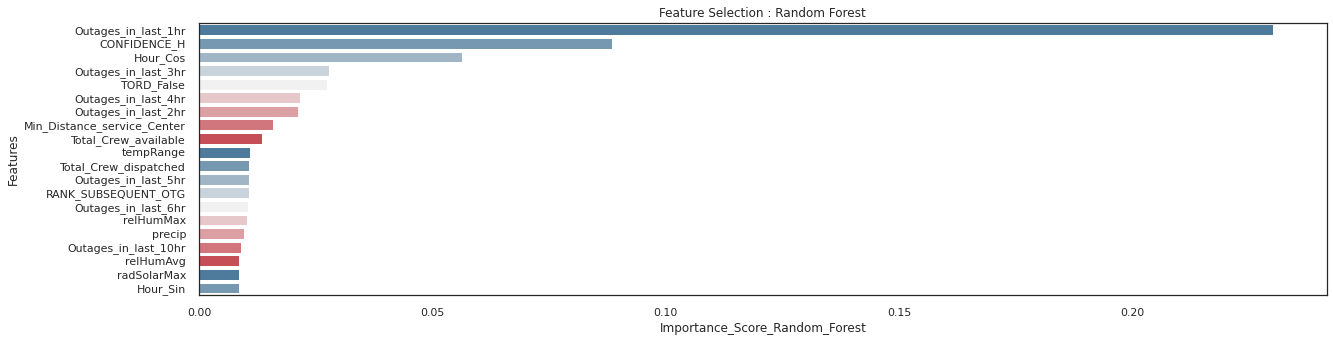

In [15]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_Random_Forest", y="Features", data=rftrees, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : Random Forest')

In [16]:
display(rftrees)

,Features,Importance_Score_Random_Forest
0,Outages_in_last_1hr,0.230064
1,CONFIDENCE_H,0.088376
2,Hour_Cos,0.056423
3,Outages_in_last_3hr,0.027933
4,TORD_False,0.027353
5,Outages_in_last_4hr,0.021561
6,Outages_in_last_2hr,0.021122
7,Min_Distance_service_Center,0.015922
8,Total_Crew_available,0.013403
9,tempRange,0.011013


## **Feature Importance using XGBoost**

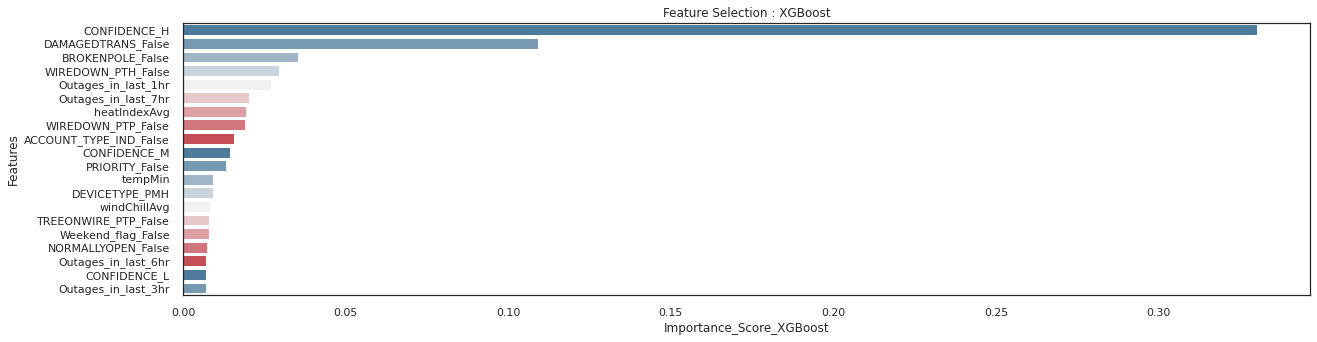

In [17]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_XGBoost", y="Features", data=xgboost, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : XGBoost')

In [18]:
display(xgboost)

,Features,Importance_Score_XGBoost
0,CONFIDENCE_H,0.330182
1,DAMAGEDTRANS_False,0.109268
2,BROKENPOLE_False,0.035291
3,WIREDOWN_PTH_False,0.029418
4,Outages_in_last_1hr,0.027138
5,Outages_in_last_7hr,0.020224
6,heatIndexAvg,0.019441
7,WIREDOWN_PTP_False,0.019217
8,ACCOUNT_TYPE_IND_False,0.015754
9,CONFIDENCE_M,0.014509


## **Final Features Selected after Union (Max Voting Regime)**

In [19]:
final_features = pd.DataFrame()
final_features['XG Boost'] = xgboost.Features
final_features['Random Forest'] = rftrees.Features
final_features['OLS'] = ols_reg.Features
final_features['PLS'] = pls_reg.Features


display(final_features)

final_features = do_union(list(xgboost.Features), list(rftrees.Features), list(ols_reg.Features), list(pls_reg.Features))
print("/n Features selected:")
print(len(final_features), "No. of Features Selected")
print(final_features)

,XG Boost,Random Forest,OLS,PLS
0,CONFIDENCE_H,Outages_in_last_1hr,sfcPresRatio,Hour_Cos
1,DAMAGEDTRANS_False,CONFIDENCE_H,CONFIDENCE_H,Outages_in_last_1hr
2,BROKENPOLE_False,Hour_Cos,DAMAGEDTRANS_True,CONFIDENCE_H
3,WIREDOWN_PTH_False,Outages_in_last_3hr,Hour_Cos,spcHumMin
4,Outages_in_last_1hr,TORD_False,Substation_crew,Outages_in_last_10hr
5,Outages_in_last_7hr,Outages_in_last_4hr,WIREDOWN_PTH_True,rank_cd
6,heatIndexAvg,Outages_in_last_2hr,BROKENPOLE_True,WIREDOWN_PTH_True
7,WIREDOWN_PTP_False,Min_Distance_service_Center,NORMALLYOPEN_False,DAMAGEDTRANS_True
8,ACCOUNT_TYPE_IND_False,Total_Crew_available,DEVICETYPE_PMH,RANK_SUBSEQUENT_OTG
9,CONFIDENCE_M,tempRange,FIREEXPLOSION_False,windSpd80mMax


/n Features selected:
62 No. of Features Selected
['FIREEXPLOSION_False', 'ACCOUNT_TYPE_IND_True', 'sfcPresRatio', 'ACCOUNT_TYPE_RES_False', 'Contractor', 'WIREDOWN_PTH_True', 'MED_CUSTS', 'radSolarMax', 'VOLTAGE_0', 'RANK_SUBSEQUENT_OTG', 'NORMALLYOPEN_False', 'DEVICETYPE_PMH', 'Outages_in_last_6hr', 'rank_cd', 'Outages_in_last_1hr', 'Total_Crew_dispatched', 'Hour_Sin', 'EMR_CUSTS', 'Outages_in_last_9hr', 'Weekend_flag_False', 'rank', 'BROKENPOLE_True', 'precip', 'WIREDOWN_PTH_False', 'Outages_in_last_3hr', 'Total_Crew_available', 'tempRange', 'Network_crew', 'spcHumMin', 'sfcPresMax', 'Outages_in_last_2hr', 'relHumRatio', 'spcHumAvg', 'VOLTAGE_12KV (95%)', 'WIREDOWN_PTP_True', 'windSpd80mMax', 'Min_Distance_service_Center', 'DAMAGEDTRANS_True', 'MAJOR', 'CONFIDENCE_M', 'CONFIDENCE_L', 'ACCOUNT_TYPE_IND_False', 'PRIORITY_True', 'CONFIDENCE_H', 'relHumAvg', 'tempMin', 'Outages_in_last_10hr', 'relHumMax', 'Outages_in_last_4hr', 'PRIORITY_False', 'Outages_in_last_7hr', 'TORD_False', 'WIR

### **View Data-set after feature selection**

In [20]:
ads_v1 = ads[final_features]
ads_v1['TTR'] = ads['TTR']
display(ads_v1.head())

,FIREEXPLOSION_False,ACCOUNT_TYPE_IND_True,sfcPresRatio,ACCOUNT_TYPE_RES_False,Contractor,WIREDOWN_PTH_True,MED_CUSTS,radSolarMax,VOLTAGE_0,RANK_SUBSEQUENT_OTG,NORMALLYOPEN_False,DEVICETYPE_PMH,Outages_in_last_6hr,rank_cd,Outages_in_last_1hr,Total_Crew_dispatched,Hour_Sin,EMR_CUSTS,Outages_in_last_9hr,Weekend_flag_False,rank,BROKENPOLE_True,precip,WIREDOWN_PTH_False,Outages_in_last_3hr,Total_Crew_available,tempRange,Network_crew,spcHumMin,sfcPresMax,Outages_in_last_2hr,relHumRatio,spcHumAvg,VOLTAGE_12KV (95%),WIREDOWN_PTP_True,windSpd80mMax,Min_Distance_service_Center,DAMAGEDTRANS_True,MAJOR,CONFIDENCE_M,CONFIDENCE_L,ACCOUNT_TYPE_IND_False,PRIORITY_True,CONFIDENCE_H,relHumAvg,tempMin,Outages_in_last_10hr,relHumMax,Outages_in_last_4hr,PRIORITY_False,Outages_in_last_7hr,TORD_False,WIREDOWN_PTP_False,windChillAvg,DAMAGEDTRANS_False,BROKENPOLE_False,Outages_in_last_5hr,Substation_crew,Hour_Cos,heatIndexAvg,sfcPresMin,TREEONWIRE_PTP_False,TTR
2,1,0,1.007925,1,0,0,0.0,381.0,0,3.0,1,0,2,1.0,2,0,0.000000,0.0,2,1,1.0,0,0.00,1,2,9,20.1,0,2.1,992.0,2,1.474576,2.8,1,0,12.3,4.162488,0,0.0,0,0,1,0,1,77.0,21.7,4,87.0,2,1,2,23.0,1,27.2,1,1,2,0,1.000000,30.7,984.2,1,4.799914
8,1,0,1.008954,0,0,0,0.0,390.3,0,9.0,1,0,4,2.0,0,1,0.500000,0.0,5,1,1.0,0,0.00,1,4,14,20.5,0,2.1,991.6,1,1.625213,2.9,0,0,12.6,11.269541,0,0.0,0,0,1,0,1,77.7,20.7,5,95.4,4,1,5,1.0,1,27.3,1,1,4,0,-0.866025,30.9,982.8,1,5.239628
9,1,0,1.008828,1,0,0,0.0,390.3,0,10.0,1,0,5,1.0,1,1,0.500000,0.0,6,1,2.0,0,0.00,1,5,14,21.4,0,2.1,994.2,2,1.684669,2.9,0,0,12.5,11.595286,0,0.0,0,0,1,0,1,76.7,20.7,6,96.7,5,1,6,5.0,1,27.9,1,1,5,0,-0.866025,31.3,985.5,1,4.023564
27,1,0,1.013576,0,1,0,0.0,180.0,0,14.0,1,0,5,1.0,0,9,-0.866025,0.0,9,1,1.0,0,0.05,1,2,19,22.6,0,1.1,993.0,2,1.333333,2.3,0,0,24.3,15.183077,0,0.0,0,0,1,0,1,87.0,8.1,11,100.0,4,1,7,1.0,1,10.1,1,1,4,0,0.500000,21.1,979.7,1,4.957586
28,1,0,1.013592,0,1,0,0.0,175.0,0,15.0,1,0,5,1.0,0,8,-0.707107,0.0,9,1,1.0,0,0.04,1,3,17,22.1,0,1.1,991.8,1,1.259740,2.1,0,0,25.1,14.041509,0,0.0,0,0,1,0,1,85.0,8.0,10,97.0,3,1,6,1.0,1,7.4,1,1,4,0,0.707107,20.0,978.5,1,6.647520


### **Correlation Matrix of Selected Variables**

In [21]:
c = ads_v1.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending = False)
so.index = so.index.set_names(['Column1', 'column2'])
so = so[so>0.97]
delete_feature = []
for i in range(len(so.index)):
    if (so.index[i][0] != so.index[i][1]):
        if(delete_feature.count(so.index[i][0]) > 0):
            continue
        else:
            delete_feature.append(so.index[i][1])
ads_v1 = ads_v1.drop(columns = delete_feature)

In [22]:
delete_feature

['PRIORITY_False',
 'ACCOUNT_TYPE_IND_True',
 'DAMAGEDTRANS_False',
 'WIREDOWN_PTP_False',
 'BROKENPOLE_True',
 'WIREDOWN_PTH_False',
 'Outages_in_last_9hr',
 'Outages_in_last_7hr',
 'windChillAvg',
 'Outages_in_last_5hr',
 'Outages_in_last_5hr',
 'Outages_in_last_4hr',
 'spcHumAvg',
 'Outages_in_last_7hr',
 'heatIndexAvg',
 'Outages_in_last_3hr',
 'Outages_in_last_4hr',
 'windChillAvg',
 'Outages_in_last_9hr']

<AxesSubplot:>

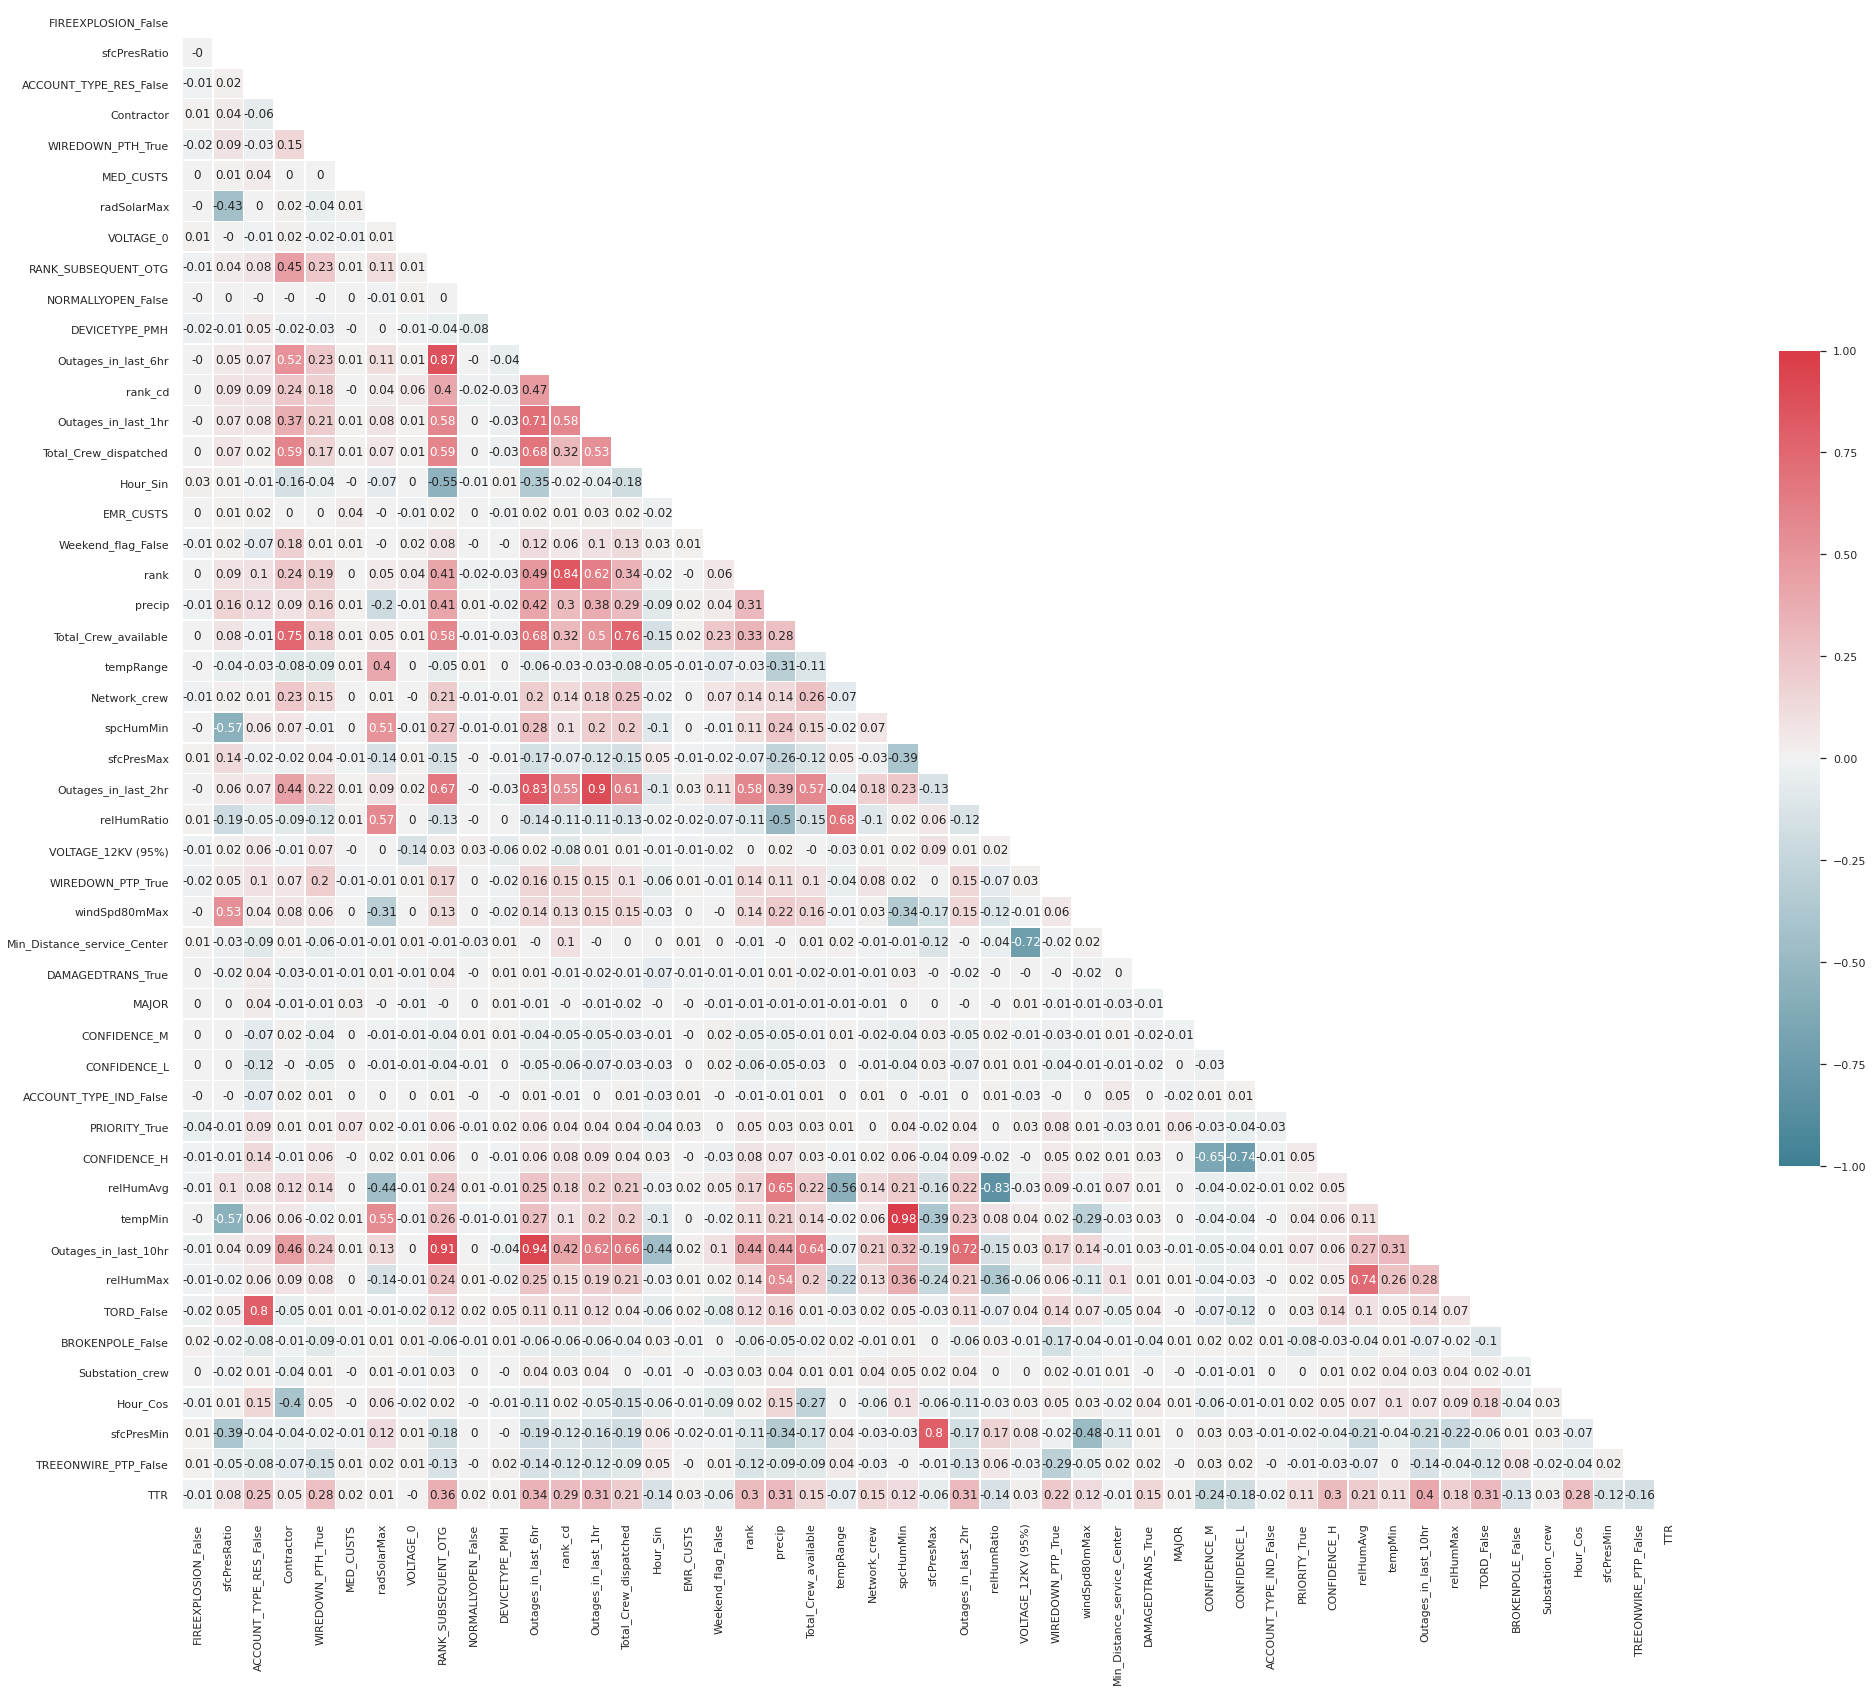

In [23]:
#whitegrid
sns.set_style('whitegrid')
#compute correlation matrix...
corr_matrix=ads_v1.corr(method='spearman')
#...and show it with a heatmap
#first define the dimension
plt.figure(figsize=(30,30))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(round(corr_matrix,2), mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### **BoxPlot of selected Variables**

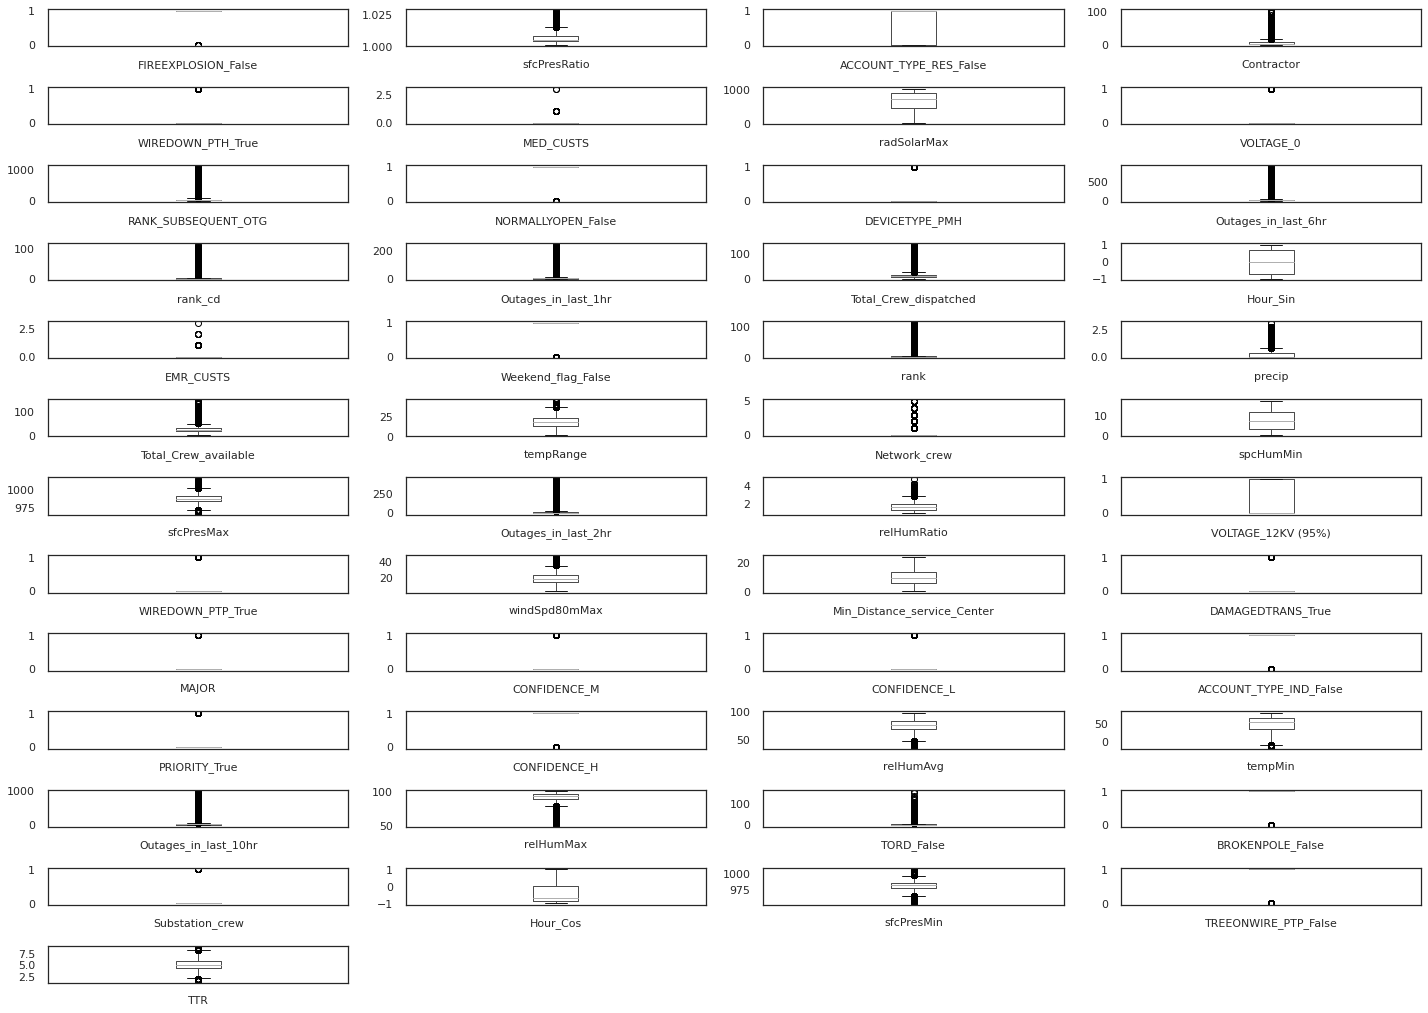

In [24]:
sns.set(rc={'figure.figsize':(20,15)})
sns.set_style("white")
for i, col in enumerate(list(ads_v1.columns.values)):
    plt.subplot(14,4,i+1)
    ads_v1.boxplot(col)
    plt.grid()
    plt.tight_layout()

### **Distribution Plot of selected Variables**

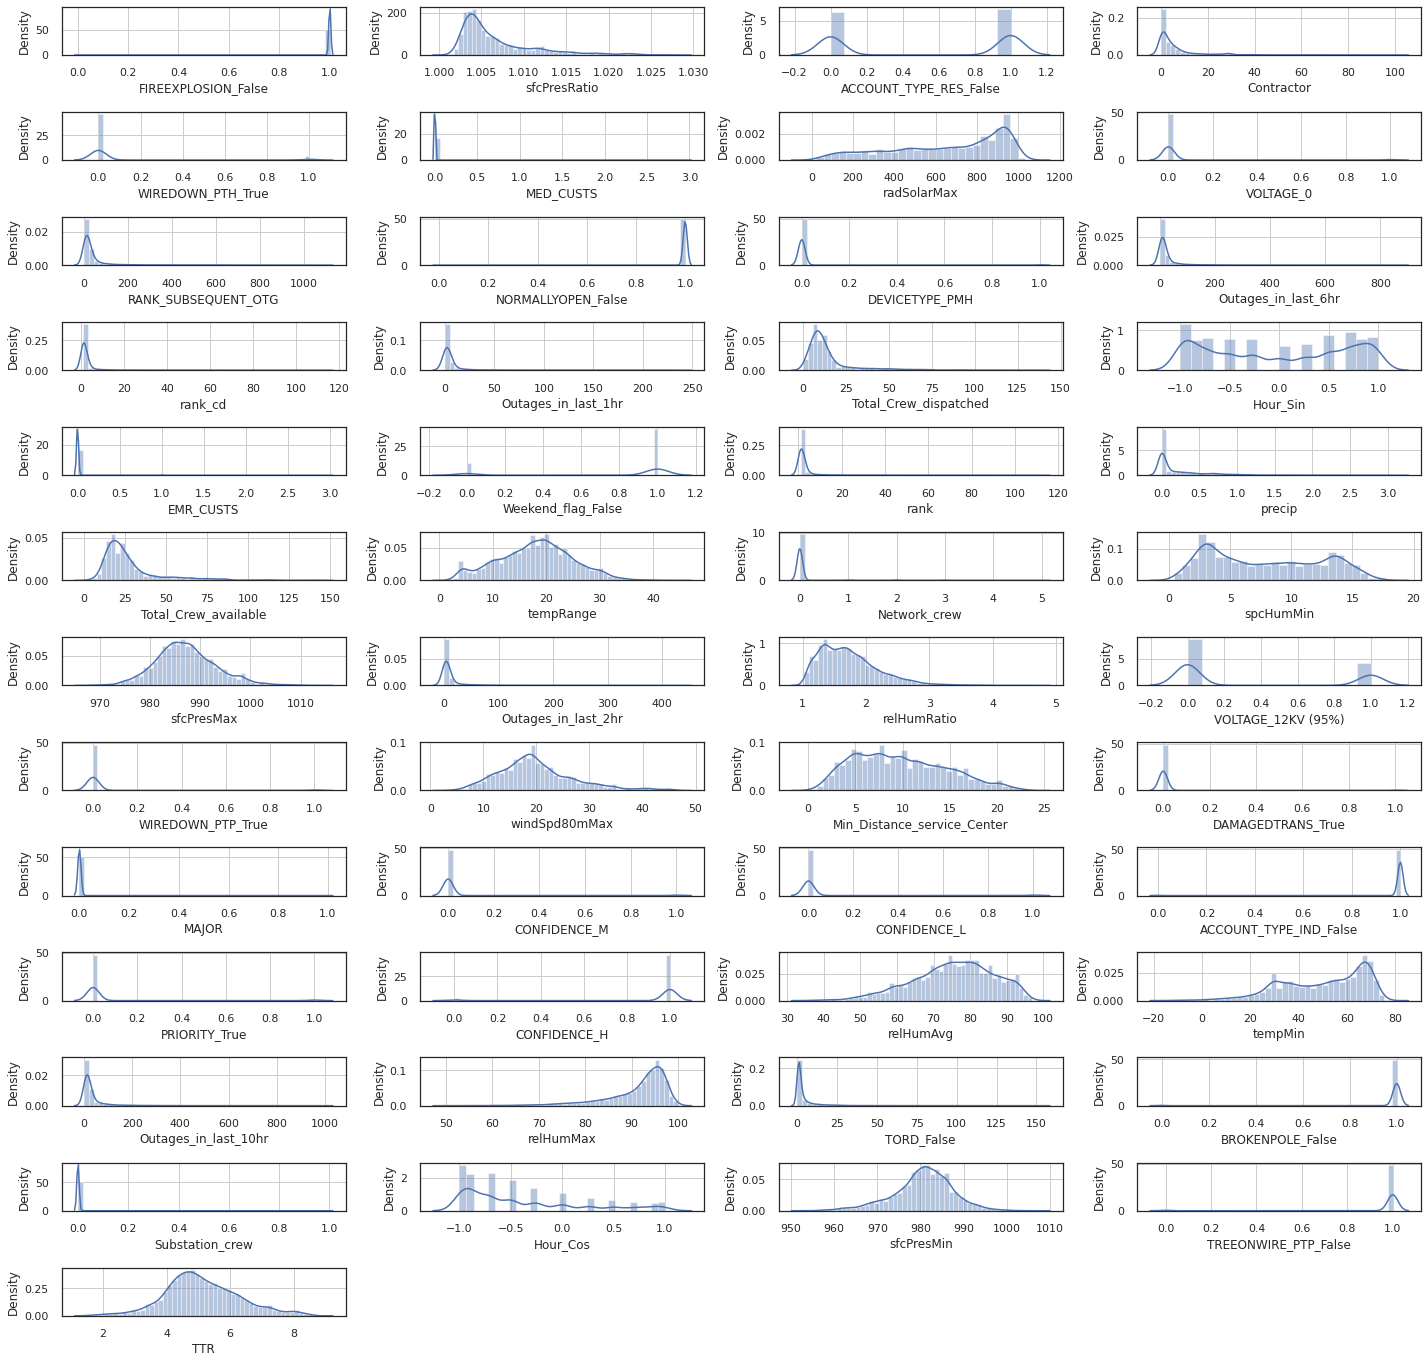

In [25]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_style("white")
for i, col in enumerate(list(ads_v1.columns.values)):
    plt.subplot(14,4,i+1)
    sns.distplot(ads_v1[col], color='b', kde=True, label='data')
    plt.grid()
    plt.tight_layout()

# **Train-Test Split using sklearn**

In [26]:
X = ads[final_features]
X['Event'] = event_
y = ads['TTR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.drop(columns = ['Event'])
event_ = X_test['Event']
X_test = X_test.drop(columns = ['Event'])
print('\n')
print('\n')
print(len(X_train),len(X_test))
print(len(y_train),len(y_test))
print('\n')
print('\n')





12531 3133
12531 3133






# **Building Baseline Random Forest Model**
- A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting
- The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [27]:
model_col = ['MODEL_NAME' , 'TRAIN_MSE', 'TRAIN_RMSE', 'TRAIN_MAE', 'TRAIN_MAPE', 'TRAIN_R2','TRAIN__Adj_R2', 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2','Test__Adj_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_train_list = pd.DataFrame() 
data_test_list = pd.DataFrame() 
i=0

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf_base = RandomForestRegressor(n_jobs = -1, random_state = 42)

rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = rf_base.predict(X_test)
y_test_pred = np.exp(y_test_pred)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

n = len(y_train)
p = len(final_features)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

data_train = pd.DataFrame({'Model':'Random Forest Baseline', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'Random Forest Baseline', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest Baseline', mse_train, rmse_train, mae_train, mape_train, r2_train,adj_r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test, adj_r2_test]
i = i + 1

In [29]:
model_result_df.head()

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TRAIN__Adj_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2,Test__Adj_R2
0,Random Forest Baseline,24329.384021,155.978793,71.813182,23.395129,0.932829,0.932495,113886.106562,337.470157,170.969079,77.244234,0.676564,0.674956


In [30]:
y_train = np.log(y_train)
y_test = np.log(y_test)

## **Random Forest Baseline: Actual vs Fitted PLot**

Text(0.5, 1.0, 'Actual vs Fitted : Random Forest Baseline')

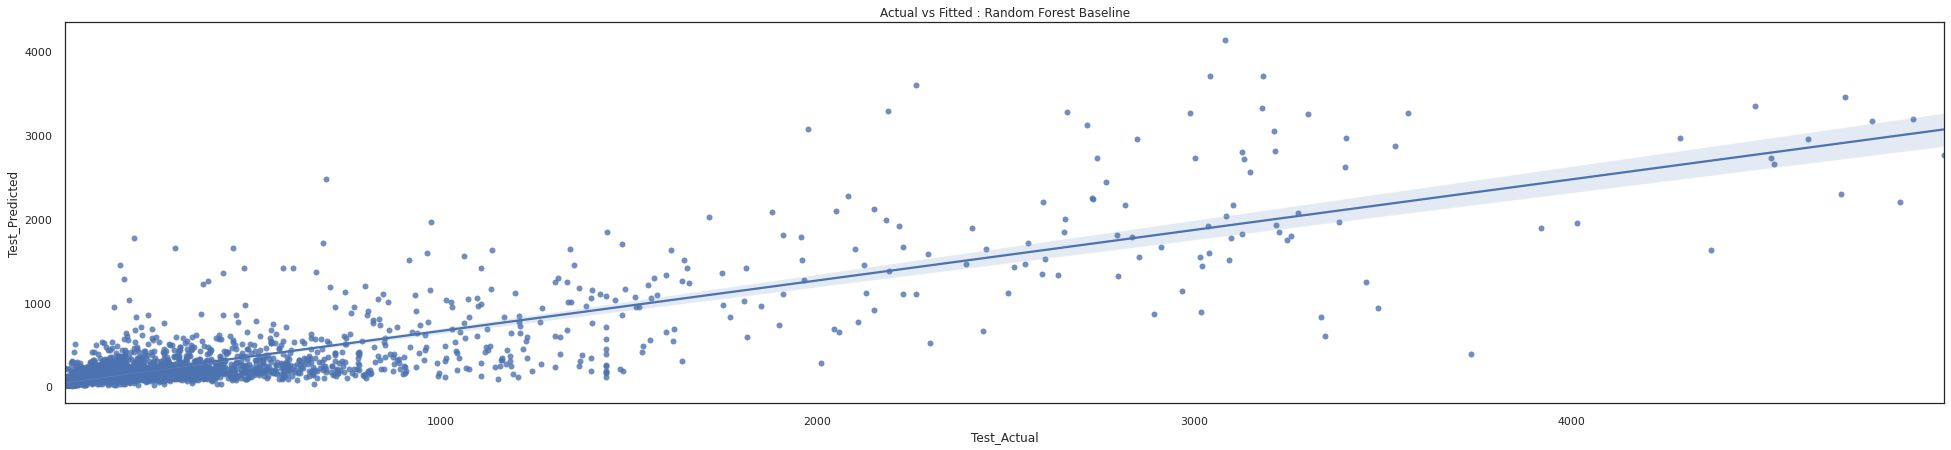

In [31]:
sns.set(rc={'figure.figsize':(30,7)})
sns.set_style("white")
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='Random Forest Baseline'])
ax.set_title('Actual vs Fitted : Random Forest Baseline')

#### **Random Forest Baseline : Residual PLot**

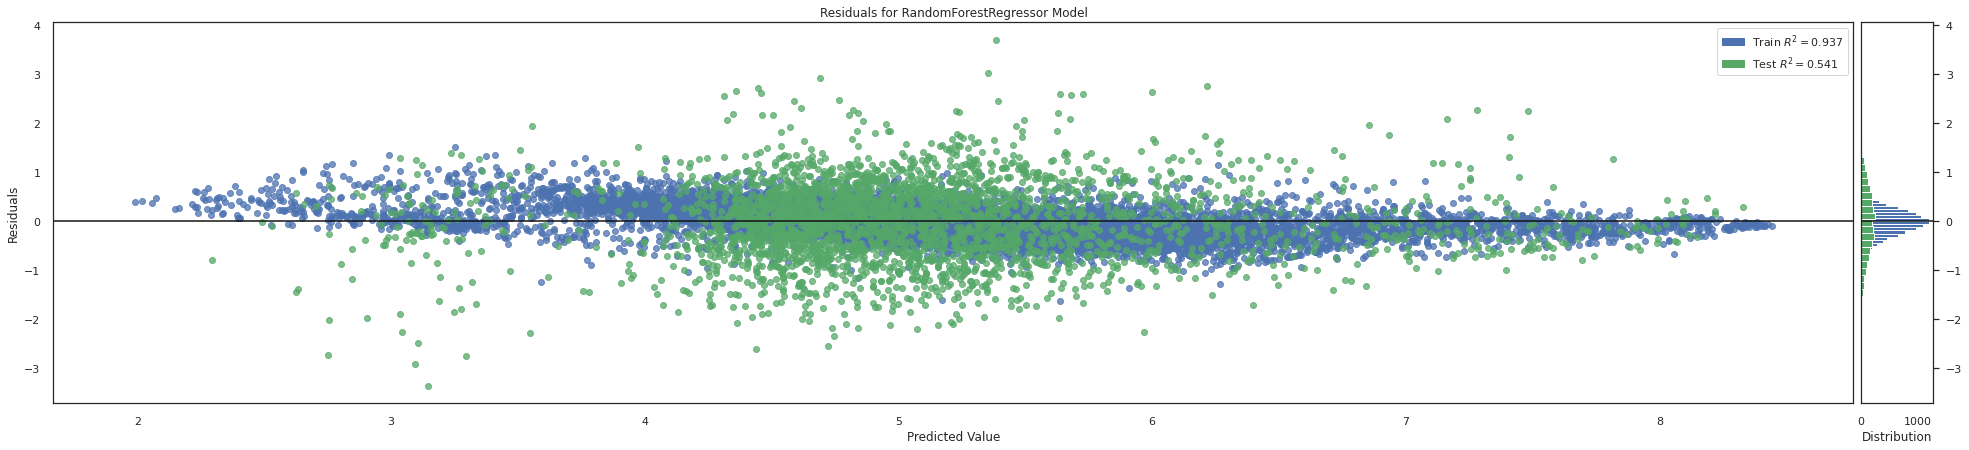

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [32]:
sns.set(rc={'figure.figsize':(30,7)})
sns.set_style("white")

visualizer = ResidualsPlot(rf_base)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data

visualizer.show()                 # Finalize and render the figure

# **Random Forest Parameters**
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [33]:
from sklearn.ensemble import RandomForestRegressor
rf_rs = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [34]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 22, 35, 47, 60, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400]}


# **Random Search Training**
- The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively)
- More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [ ]:
%%time

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_rs = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_rs_random = RandomizedSearchCV(estimator = rf_rs, param_distributions = random_grid, n_iter = 150, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_rs_random.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 74.3min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 93.7min finished


CPU times: user 25.6 s, sys: 551 ms, total: 26.2 s
Wall time: 1h 34min 3s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 22, 35, 47, 60, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42, verbose=2)

In [ ]:
print(rf_rs_random.best_params_)

{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 22, 'bootstrap': False}


#### **Building Random Search Best Model**

In [ ]:
rf_rs = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_rs.set_params(**rf_rs_random.best_params_)

rf_rs.fit(X_train, y_train)

y_train_pred = rf_rs.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = rf_rs.predict(X_test)
y_test_pred = np.exp(y_test_pred)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

data_train = pd.DataFrame({'Model':'Random Forest Random Search', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'Random Forest Random Search', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest Random Search', mse_train, rmse_train, mae_train, mape_train, r2_train,adj_r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test,adj_r2_test]
i = i + 1

In [ ]:
model_result_df.head()

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TRAIN__Adj_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2,Test__Adj_R2
0,Random Forest Baseline,24329.384021,155.978793,71.813182,23.395129,0.932829,0.932495,113886.106562,337.470157,170.969079,77.244234,0.676564,0.674956
1,Random Forest Random Search,29688.030986,172.302150,85.867603,34.455009,0.918035,0.917627,115273.134158,339.518975,171.464875,76.348052,0.672625,0.670997


In [ ]:
y_train = np.log(y_train)
y_test = np.log(y_test)

#### **Random Forest Random Search: Actual vs Fitted PLot**

Text(0.5, 1.0, 'Actual vs Fitted : Random Forest Random Search')

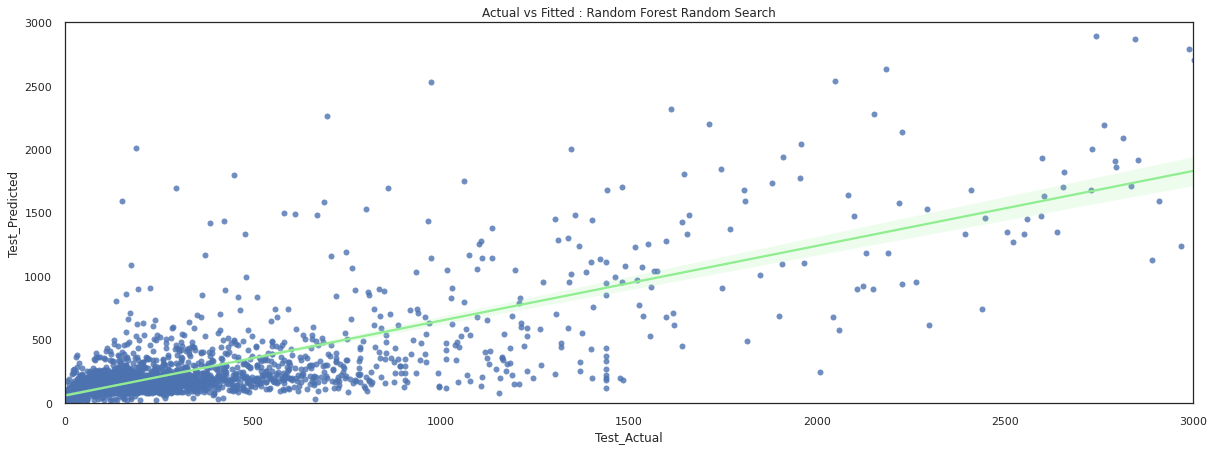

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("white")
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='Random Forest Random Search'], line_kws={"color": "lightgreen"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Random Search')

#### **Random Forest Random Search: Residual PLot**

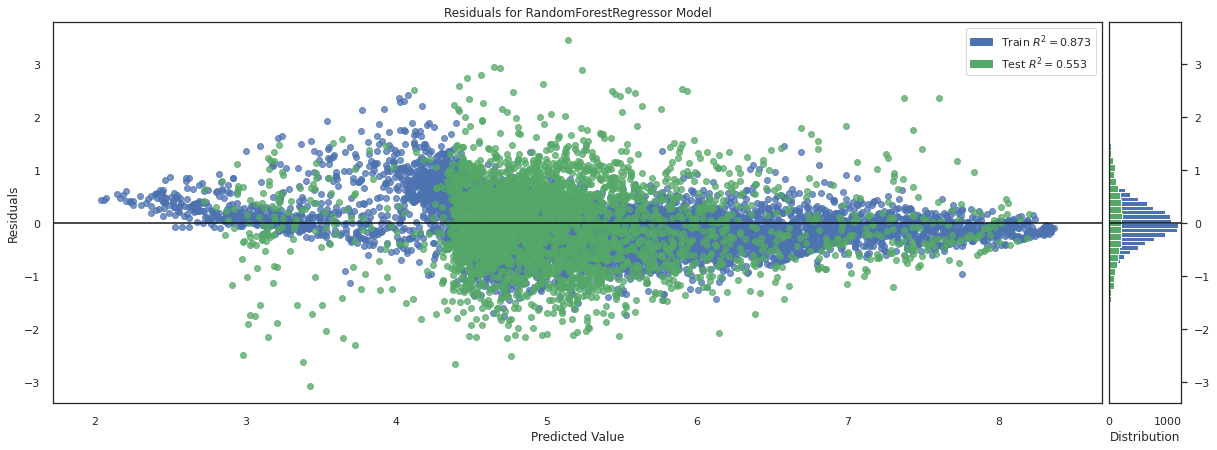

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("white")

visualizer = ResidualsPlot(rf_rs)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data

visualizer.show()                 # Finalize and render the figure

# **Grid Search with Cross Validation**
- Random search allowed us to narrow down the range for each hyperparameter
- Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try
- We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [35, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4, 6, 8, 10],
    'n_estimators': [400, 450, 500, 550, 600]
}

# Create a based model
rf_gs = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_gs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("Best Paramters for Random Forest Model using Grid Search:")
print(grid_search.best_params_)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 36.1min finished


Best Paramters for Random Forest Model using Grid Search:
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 450}


#### **Building Grid Search Best Model**

In [ ]:
rf_gs = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_gs.set_params(**grid_search.best_params_)

rf_gs.fit(X_train, y_train)

y_train_pred = rf_gs.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = rf_gs.predict(X_test)
y_test_pred = np.exp(y_test_pred)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

data_train = pd.DataFrame({'Model':'Random Forest Grid Search', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'Random Forest Grid Search', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest Grid Search', mse_train, rmse_train, mae_train, mape_train, r2_train,adj_r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test,adj_r2_test]
i = i + 1

In [ ]:
model_result_df.head()

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TRAIN__Adj_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2,Test__Adj_R2
0,Random Forest Baseline,24329.384021,155.978793,71.813182,23.395129,0.932829,0.932495,113886.106562,337.470157,170.969079,77.244234,0.676564,0.674956
1,Random Forest Random Search,29688.030986,172.302150,85.867603,34.455009,0.918035,0.917627,115273.134158,339.518975,171.464875,76.348052,0.672625,0.670997
2,Random Forest Grid Search,33690.478037,183.549661,80.184978,24.952855,0.906984,0.906522,116070.424839,340.691099,171.903436,76.627513,0.670361,0.668722


In [ ]:
data_train_list.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/Train_Data_DPL_RF_DSB_10222020.csv')
data_test_list.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/Test_Data_DPL_RF_DSB_10222020.csv')

In [ ]:
y_train = np.log(y_train)
y_test = np.log(y_test)

#### **Random Forest Grid Search: Actual vs Fitted Plot**

Text(0.5, 1.0, 'Actual vs Fitted : Random Forest Grid Search CV')

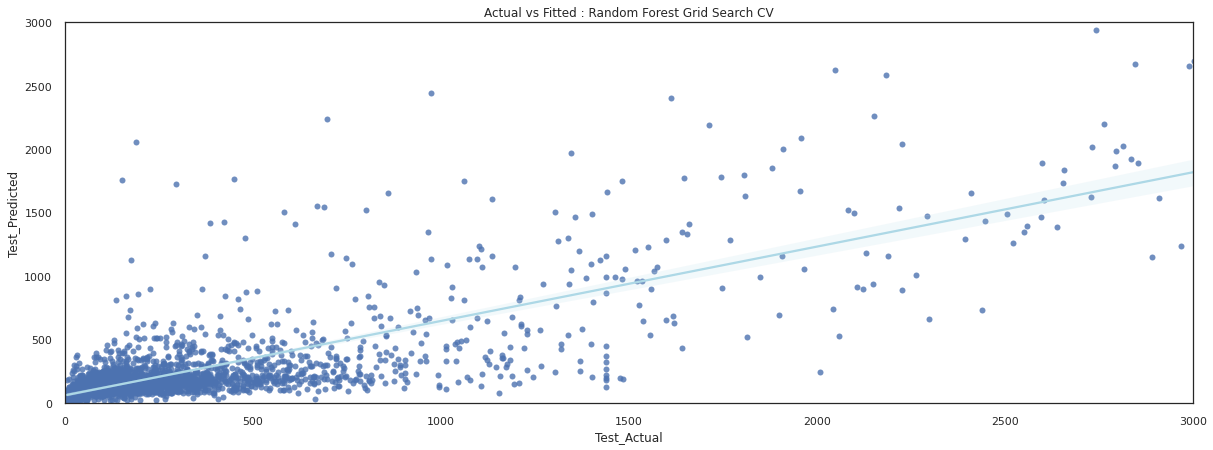

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("white")
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='Random Forest Grid Search'], line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Grid Search CV')

#### **Random Forest Grid Search: Residual PLot**

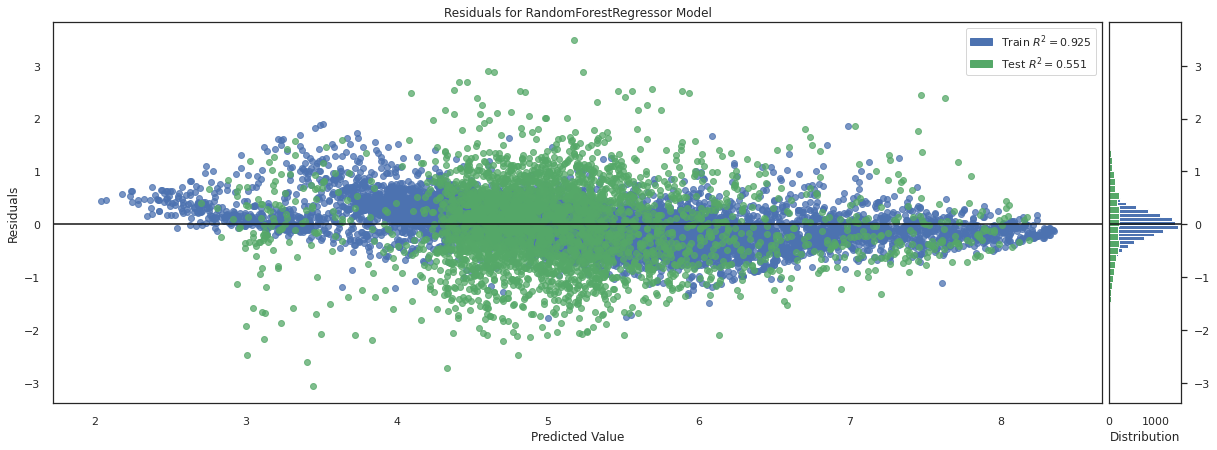

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("white")

visualizer = ResidualsPlot(rf_gs)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data

visualizer.show()                 # Finalize and render the figure

# **Selecting the best model**

In [ ]:
model_result_df

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TRAIN__Adj_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2,Test__Adj_R2
0,Random Forest Baseline,24329.384021,155.978793,71.813182,23.395129,0.932829,0.932495,113886.106562,337.470157,170.969079,77.244234,0.676564,0.674956
1,Random Forest Random Search,29688.030986,172.302150,85.867603,34.455009,0.918035,0.917627,115273.134158,339.518975,171.464875,76.348052,0.672625,0.670997
2,Random Forest Grid Search,33690.478037,183.549661,80.184978,24.952855,0.906984,0.906522,116070.424839,340.691099,171.903436,76.627513,0.670361,0.668722


## **Model business metric** Storm + Bluesky

In [53]:
rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = rf_gs.predict(X_test)
y_test_pred = np.exp(y_test_pred)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

business_KPI = customer_metrics(y_test,y_test_pred)
y_train = np.log(y_train)
y_test = np.log(y_test)
y_test_pred = np.log(y_test_pred)

df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage

Predicted_Values,0-120,120-240,240-360,360-480,480-600,600-720,>720,total
Actual_Values,,,,,,,,
0-120,24.8%,15.8%,1.1%,0.2%,0.0%,0.0%,0.0%,41.9%
120-240,9.0%,12.2%,2.3%,0.5%,0.2%,0.1%,0.3%,24.5%
240-360,2.0%,5.4%,1.5%,0.7%,0.4%,0.1%,0.0%,10.1%
360-480,0.9%,2.9%,1.1%,0.6%,0.2%,0.0%,0.3%,6.0%
480-600,0.3%,1.9%,1.1%,0.4%,0.2%,0.1%,0.2%,4.1%
600-720,0.2%,0.9%,0.6%,0.3%,0.2%,0.0%,0.2%,2.5%
>720,0.2%,1.6%,1.3%,0.9%,0.6%,0.7%,5.7%,11.0%
total,37.3%,40.6%,8.9%,3.6%,1.9%,1.0%,6.6%,100.0%


## Splitting the metric in Storm and Blue sky events

In [54]:
df_result = pd.DataFrame(data={'y_test': np.exp(y_test), 'y_test_pred': np.exp(y_test_pred) , 'EVENT': event_})
df_result.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/Testdata_DPL_RF_DSB_10222020.csv')
model_col = ['EVENT' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE']
best_model_result_df = pd.DataFrame(columns=model_col)
i=0

In [55]:
mse_test = mean_squared_error(df_result.y_test, df_result.y_test_pred)
rmse_test = rmse(df_result.y_test, df_result.y_test_pred)
mae_test = mean_absolute_error(df_result.y_test, df_result.y_test_pred)
mape_test = mean_absolute_percentage_error(df_result.y_test, df_result.y_test_pred)
best_model_result_df.loc[i] = ['Random Forest Grid Search All', mse_test, rmse_test, mae_test, mape_test]
i = i + 1

mse_test = mean_squared_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
rmse_test = rmse(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
mae_test = mean_absolute_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
mape_test = mean_absolute_percentage_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
best_model_result_df.loc[i] = ['Random Forest Grid Search Storm',mse_test, rmse_test, mae_test, mape_test]
i = i + 1

mse_test = mean_squared_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
rmse_test = rmse(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
mae_test = mean_absolute_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
mape_test = mean_absolute_percentage_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
best_model_result_df.loc[i] = ['Random Forest Grid Search Bluesky', mse_test, rmse_test, mae_test, mape_test]
i = i + 1

best_model_result_df

,EVENT,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE
0,Random Forest Grid Search All,116070.424839,340.691099,171.903436,76.627513
1,Random Forest Grid Search Storm,864774.304849,929.932420,692.741004,66.271235
2,Random Forest Grid Search Bluesky,40568.663221,201.416641,119.380462,77.671874


### Residual plot

#### Storm + Bluesky

[Text(0.5, 0, 'Actual TTR'), Text(0, 0.5, 'Predicted TTR')]

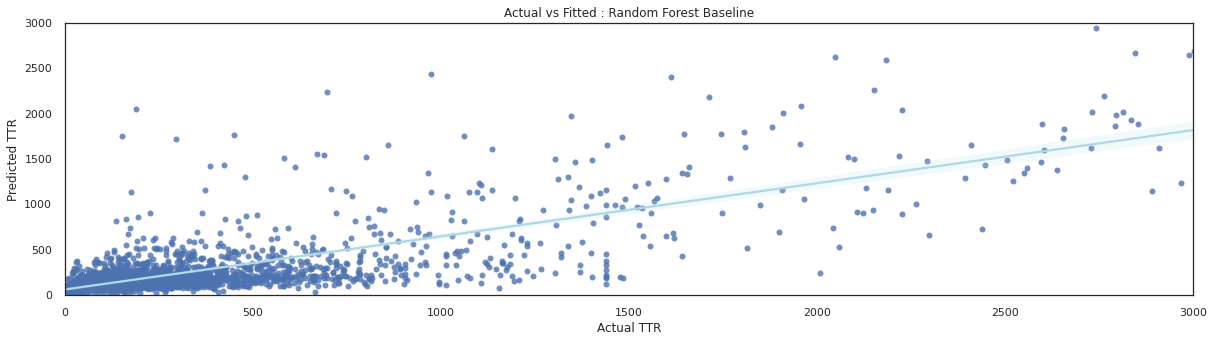

In [56]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result, line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

#### Storm

[Text(0.5, 0, 'Actual TTR'), Text(0, 0.5, 'Predicted TTR')]

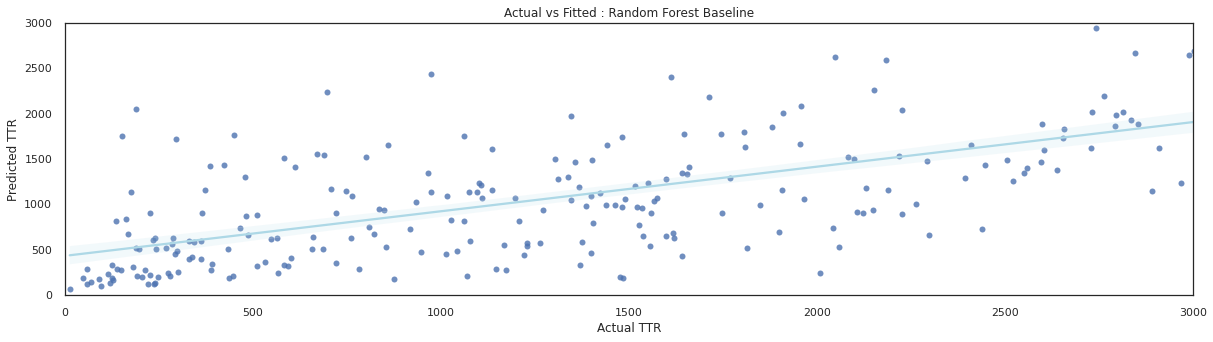

In [57]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result[df_result.EVENT == 'STORM'], line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

#### Bluesky

[Text(0.5, 0, 'Actual TTR'), Text(0, 0.5, 'Predicted TTR')]

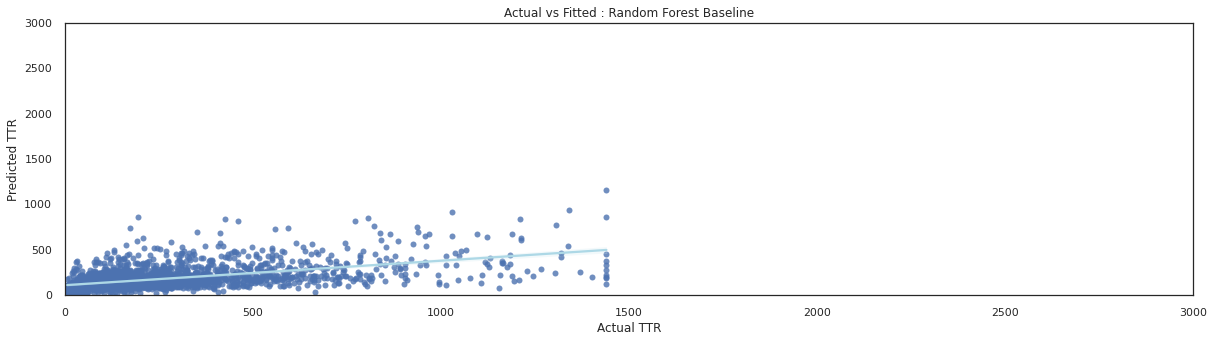

In [58]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result[df_result.EVENT == 'BLUE SKY'], line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

## Business metrics for Storm Events

In [59]:
business_KPI = customer_metrics_storm(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage

Predicted_Values,0-120,1080-1200,120-240,1200-1320,1200-1440,240-360,360-480,480-600,600-720,720-840,840-960,960-1080,>1440,total
Actual_Values,,,,,,,,,,,,,,
0-120,1.0%,0.0%,1.7%,0.0%,0.0%,0.3%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,3.1%
1080-1200,0.0%,0.7%,0.0%,0.7%,0.0%,0.7%,0.0%,0.3%,0.0%,0.0%,0.0%,0.7%,0.3%,3.5%
120-240,0.3%,0.3%,2.4%,0.0%,0.0%,1.7%,0.0%,0.7%,1.0%,0.7%,0.3%,0.0%,0.7%,8.4%
1200-1320,0.0%,0.0%,0.0%,0.3%,0.0%,0.0%,0.3%,1.0%,0.0%,0.3%,0.3%,0.0%,0.3%,2.8%
1200-1440,0.0%,1.0%,0.0%,0.3%,0.0%,0.3%,0.3%,0.3%,0.0%,0.3%,0.0%,1.0%,1.0%,4.9%
240-360,0.0%,0.0%,1.0%,0.0%,0.0%,0.3%,1.0%,2.1%,0.3%,0.0%,0.0%,0.0%,0.3%,5.2%
360-480,0.0%,0.3%,0.7%,0.3%,0.7%,0.7%,0.3%,0.7%,0.0%,0.3%,0.3%,0.0%,0.3%,4.9%
480-600,0.0%,0.0%,0.3%,0.0%,0.0%,1.0%,0.7%,0.0%,1.0%,0.0%,0.7%,0.0%,0.3%,4.2%
600-720,0.0%,0.3%,0.0%,0.0%,0.3%,0.0%,0.0%,0.7%,0.3%,0.0%,0.3%,0.0%,1.0%,3.1%


## Business metrics for Blue sky Events

In [60]:
business_KPI = customer_metrics(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage

Predicted_Values,0-120,120-240,240-360,360-480,480-600,600-720,>720,total
Actual_Values,,,,,,,,
0-120,27.2%,17.3%,1.2%,0.2%,0.0%,0.0%,0.0%,45.8%
120-240,9.8%,13.1%,2.4%,0.5%,0.2%,0.0%,0.1%,26.1%
240-360,2.2%,5.8%,1.7%,0.6%,0.2%,0.0%,0.0%,10.6%
360-480,0.9%,3.1%,1.1%,0.6%,0.2%,0.0%,0.1%,6.1%
480-600,0.4%,2.0%,1.1%,0.4%,0.2%,0.0%,0.1%,4.1%
600-720,0.2%,1.0%,0.6%,0.4%,0.2%,0.0%,0.0%,2.4%
>720,0.2%,1.6%,1.2%,0.8%,0.4%,0.4%,0.4%,4.9%
total,40.9%,43.9%,9.2%,3.5%,1.3%,0.5%,0.6%,100.0%


## **Saving Model Object using Pickle File**

In [61]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/DPL_RF_baseline_DSB_10222020.pkl', 'wb') as f:
    pickle.dump(rf_base, f)

## **Load Model Object using Pickle File**

In [62]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')

with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/DPL_RF_baseline_DSB_10222020.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# **Out of Sample Validation**

In [63]:
df_all = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_test_dataset/DPL_2020_Out_of_Sample_Validation.csv')
df_all = df_all[df_all.Nearest_service_center_DSB == 1]
df_all['customers_tot'] = df_all['Customers']
df_all = pd.get_dummies(df_all, columns=['FIREEXPLOSION', 'ACCOUNT_TYPE_COM', 'ACCOUNT_TYPE_CUS', 'ACCOUNT_TYPE_GOV', 'ACCOUNT_TYPE_IND','VOLTAGE'])
df_all['NORMALLYOPEN_False'] = 0
event_ = df_all['EVENT']
df_all.tail()

,OUTAGE_ID,CIRCUIT,DEVICE,TIME_OF_FIRST_CALL,PHASE_A,PHASE_B,PHASE_C,PHASE_T,LFS_CUSTS,MED_CUSTS,EMR_CUSTS,UTL_CUSTS,MAJ_CUSTS,GOV_CUSTS,LRT_CUSTS,STATUS,LATITUDE,LONGITUDE,CUSTSTILLOUT,TTR,MAJOR,TORD_False,TORD_True,FROMDATE,TODATE,STORM_TYPE,EVENT,Day_flag,Hour_Sin,Hour_Cos,DATE,RANK_SUBSEQUENT_OTG,Marker_Location,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Min_Distance_service_Center,Resource_count_at_First_call,Resource_count_non_DPL,Crew_lead_count,cldCvrMin,cldCvrAvg,cldCvrMax,dewPtMin,dewPtAvg,dewPtMax,feelsLikeMin,feelsLikeAvg,feelsLikeMax,heatIndexMin,heatIndexAvg,heatIndexMax,mslPresMin,mslPresAvg,mslPresMax,precip,radSolarMin,radSolarAvg,radSolarMax,radSolarTot,relHumMin,relHumAvg,relHumMax,sfcPresMin,sfcPresAvg,sfcPresMax,snowfall,spcHumMin,spcHumAvg,spcHumMax,tempMin,tempAvg,tempMax,windChillMin,windChillAvg,windChillMax,windDirAvg,windDir80mAvg,windDir100mAvg,windSpdMin,windSpdAvg,windSpdMax,windSpd80mMin,windSpd80mAvg,windSpd80mMax,windSpd100mMin,windSpd100mAvg,windSpd100mMax,wetBulbMin,wetBulbAvg,wetBulbMax,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Offical_storm,DEVICESIZE,TOTCUST_A,TOTCUST_B,TOTCUST_C,TOTCUST_T,UNDERGD,NORMALLYOPEN,TOTKVA_A,TOTKVA_B,TOTKVA_C,Total_Crew_dispatched,Total_Crew_available,Line_crew,Service_crew,Substation_crew,Network_crew,Contractor,Total_cust,WIREDOWN_PTP_False,WIREDOWN_PTP_True,DAMAGEDTRANS_False,DAMAGEDTRANS_True,PRIORITY_False,PRIORITY_True,Weekend_flag_False,Weekend_flag_True,Nearest_service_center_DSB,Nearest_service_center_Eaton,Nearest_service_center_Greenville,Nearest_service_center_Marysville,Nearest_service_center_North Dayton,Nearest_service_center_Sidney,Nearest_service_center_Washington Court House,Nearest_service_center_Xenia,TREEONWIRE_PTH_False,TREEONWIRE_PTH_True,BROKENPOLE_False,BROKENPOLE_True,WIREDOWN_PTH_False,WIREDOWN_PTH_True,TOPFUSE_False,TOPFUSE_True,TREEONWIRE_PTP_False,TREEONWIRE_PTP_True,CONFIDENCE_H,CONFIDENCE_L,CONFIDENCE_M,ACCOUNT_TYPE_RES_False,ACCOUNT_TYPE_RES_True,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,DEVICETYPE_3 Phs Rec,DEVICETYPE_AB SWITCH,DEVICETYPE_CKT BKR,DEVICETYPE_F RISER,DEVICETYPE_FUSE,DEVICETYPE_NO DEVICE,DEVICETYPE_PMH,DEVICETYPE_RECLOSER,DEVICETYPE_S RISER,DEVICETYPE_SOLID,DEVICETYPE_SWTCHGEAR,Date,Customers,rank,rank_cd,customers_tot,FIREEXPLOSION_False,FIREEXPLOSION_True,ACCOUNT_TYPE_COM_False,ACCOUNT_TYPE_COM_True,ACCOUNT_TYPE_CUS_False,ACCOUNT_TYPE_GOV_False,ACCOUNT_TYPE_GOV_True,ACCOUNT_TYPE_IND_False,ACCOUNT_TYPE_IND_True,VOLTAGE_0,VOLTAGE_12KV (100%),VOLTAGE_12KV (95%),VOLTAGE_13.8KV,VOLTAGE_4KV,NORMALLYOPEN_False
4863,1386870,AV1230,5485,6/30/2020 13:27,True,False,False,False,1,0,0,0,0,0,0,6,39.738343,-84.251012,0,69.58,0,1,0,NaN,NaN,others,BLUE SKY,True,-0.258819,-9.659258e-01,6/30/2020,23,Marker 26,1,5,8,12,15,18,19,19,19,19,3.263214,71,24,52,0,26,96,67.4,69.4,71.8,70.2,78.5,92.7,70.2,78.5,92.7,1010.8,1012.4,1013.5,0.15,0,249.4,735.7,5987.1,56.0,80.1,92.1,981.3,982.5,983.5,0.0,14.7,15.8,17.2,70.2,76.3,86.9,70.2,76.3,86.9,291,246,246,0.4,2.4,5.7,1.2,7.0,12.0,1.4,5.8,10.1,68.3,71.5,75.3,16.7,5.3,2.2,96,36.1,1.644643,1.002242,1,50K,110,0,0,0,False,False,475.0,0.0,0.0,15,24,24,0,0,0,10,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,6/30/2020,110,1,1,110,1,0,1,0,1,1,0,1,0,0,0,1,0,0,0
4866,1386882,RJ1205,7237,6/30/2020 14:23,True,False,False,False,0,0,0,0,0,0,0,6,39.668738,-84.176425,0,60.07,0,1,0,NaN,NaN,others,BLUE SKY,True,-0.500000,-8.660254e-01,6/30/2020,27,Marker 26,4,5,9,12,17,20,22,23,23,23,7.381382,73,26,54,0,26,96,67.4,69.4,71.8,70.2,78.5,92.7,70.2,78.5,92.7,1010.8,1012.4,1013.5,0.15,0,249.4,735.7,5987.1,56.0,80.1,92.1,981.3,982.5,983.5,0.0,14.7,15.8,17.2,70.2,76.3,86.9,70.2,76.3,86.9,291,246,246,0

In [64]:
X = df_all[final_features]
y = np.log(df_all.TTR)

y_test_pred = rf_model.predict(X)

df_result = pd.DataFrame(data={'y_test': np.exp(y), 'y_test_pred': np.exp(y_test_pred) , 'EVENT': event_})

model_col = ['EVENT' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'R2_Score']
validation_result_df = pd.DataFrame(columns=model_col)
i=0

In [65]:
mse_test = mean_squared_error(df_result.y_test, df_result.y_test_pred)
rmse_test = rmse(df_result.y_test, df_result.y_test_pred)
mae_test = mean_absolute_error(df_result.y_test, df_result.y_test_pred)
mape_test = mean_absolute_percentage_error(df_result.y_test, df_result.y_test_pred)
r2_test = r2_score(df_result.y_test, df_result.y_test_pred)

validation_result_df.loc[i] = ['2020 Validation Storm + Blue sky', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

mse_test = mean_squared_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
rmse_test = rmse(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
mae_test = mean_absolute_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
mape_test = mean_absolute_percentage_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
r2_test = r2_score(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
validation_result_df.loc[i] = ['2020 Validation Storm', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

mse_test = mean_squared_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
rmse_test = rmse(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
mae_test = mean_absolute_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
mape_test = mean_absolute_percentage_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
r2_test = r2_score(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
validation_result_df.loc[i] = ['2020 Validation Blue sky', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

validation_result_df

,EVENT,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,R2_Score
0,2020 Validation Storm + Blue sky,40672.036449,201.673093,121.632495,79.509478,0.353977
1,2020 Validation Storm,69622.203096,263.860196,166.669784,69.049412,0.304003
2,2020 Validation Blue sky,39318.961474,198.290094,119.527539,79.998361,0.352063


## Business metrics for Storm + Blue sky Events

In [66]:
business_KPI = customer_metrics(df_result.y_test, df_result.y_test_pred)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage

Predicted_Values,0-120,120-240,240-360,360-480,480-600,600-720,>720,total
Actual_Values,,,,,,,,
0-120,23.5%,18.2%,2.2%,0.2%,0.0%,0.0%,0.0%,44.2%
120-240,8.7%,11.9%,2.7%,0.5%,0.1%,0.1%,0.0%,23.9%
240-360,1.8%,5.4%,3.5%,0.3%,0.2%,0.0%,0.1%,11.3%
360-480,0.8%,4.9%,2.4%,0.7%,0.0%,0.1%,0.0%,8.9%
480-600,0.4%,1.6%,1.1%,0.4%,0.9%,0.0%,0.0%,4.4%
600-720,0.0%,0.9%,0.2%,0.4%,0.2%,0.1%,0.1%,1.9%
>720,0.3%,1.2%,0.9%,0.8%,0.7%,0.5%,1.1%,5.5%
total,35.4%,44.2%,13.1%,3.2%,2.0%,0.7%,1.3%,100.0%


## Business metrics for Storm Events

In [70]:
business_KPI = customer_metrics_storm(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage

Predicted_Values,0-120,1080-1200,120-240,240-360,360-480,480-600,600-720,total
Actual_Values,,,,,,,,
0-120,8.3%,0.0%,6.2%,2.1%,2.1%,0.0%,0.0%,18.8%
1080-1200,0.0%,2.1%,0.0%,0.0%,0.0%,2.1%,0.0%,4.2%
120-240,4.2%,0.0%,12.5%,6.2%,2.1%,2.1%,2.1%,29.2%
240-360,0.0%,0.0%,8.3%,10.4%,2.1%,2.1%,0.0%,22.9%
360-480,0.0%,0.0%,4.2%,6.2%,0.0%,0.0%,0.0%,10.4%
480-600,2.1%,0.0%,2.1%,0.0%,0.0%,2.1%,0.0%,6.2%
720-840,0.0%,0.0%,0.0%,0.0%,0.0%,2.1%,0.0%,2.1%
840-960,0.0%,0.0%,0.0%,2.1%,2.1%,0.0%,0.0%,4.2%
>1440,0.0%,0.0%,0.0%,0.0%,2.1%,0.0%,0.0%,2.1%


## Business metrics for Blue sky Events

In [68]:
business_KPI = customer_metrics(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage

Predicted_Values,0-120,120-240,240-360,360-480,480-600,600-720,>720,total
Actual_Values,,,,,,,,
0-120,24.2%,18.8%,2.2%,0.1%,0.0%,0.0%,0.0%,45.4%
120-240,8.9%,11.9%,2.5%,0.4%,0.0%,0.0%,0.0%,23.7%
240-360,1.9%,5.3%,3.2%,0.2%,0.1%,0.0%,0.1%,10.7%
360-480,0.9%,5.0%,2.2%,0.7%,0.0%,0.1%,0.0%,8.9%
480-600,0.3%,1.6%,1.2%,0.4%,0.9%,0.0%,0.0%,4.3%
600-720,0.0%,1.0%,0.2%,0.4%,0.2%,0.1%,0.1%,1.9%
>720,0.3%,1.3%,0.9%,0.7%,0.5%,0.5%,1.1%,5.2%
total,36.4%,44.7%,12.5%,2.8%,1.7%,0.7%,1.3%,100.0%


### Residual plot

#### Storm + Bluesky

[Text(0.5, 0, 'Actual TTR'), Text(0, 0.5, 'Predicted TTR')]

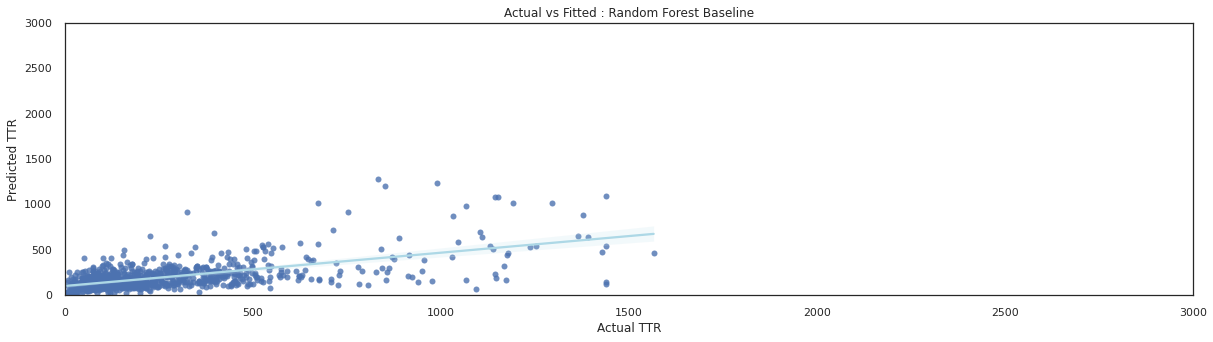

In [71]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result, line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

#### Storm

[Text(0.5, 0, 'Actual TTR'), Text(0, 0.5, 'Predicted TTR')]

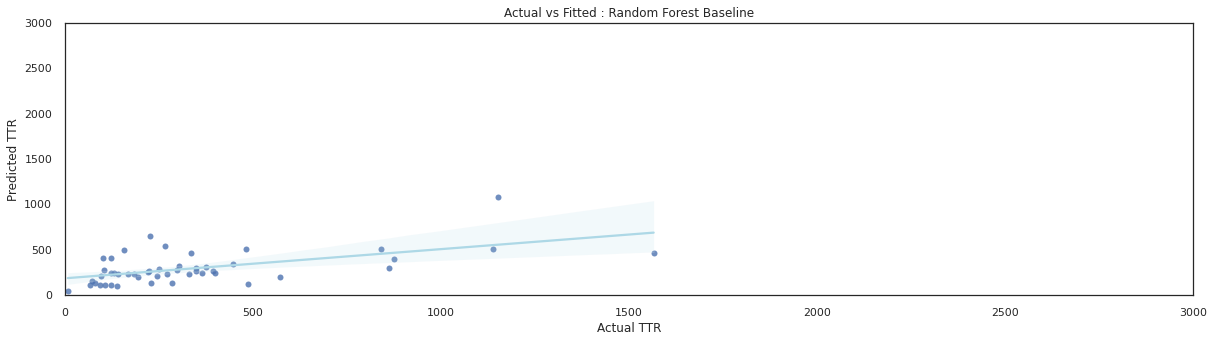

In [72]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result[df_result.EVENT == 'STORM'], line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

#### Bluesky

[Text(0.5, 0, 'Actual TTR'), Text(0, 0.5, 'Predicted TTR')]

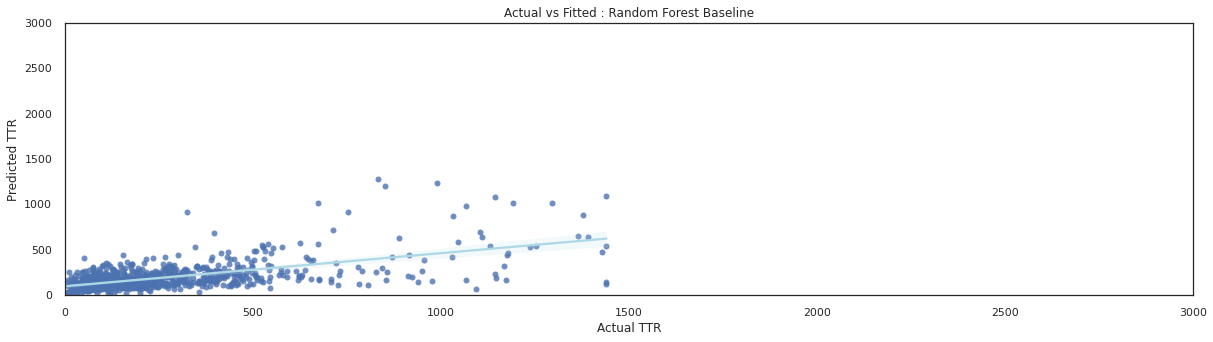

In [73]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result[df_result.EVENT == 'BLUE SKY'], line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

Text(0.5, 1.0, 'Actual vs Fitted : Random Forest Grid Search CV')

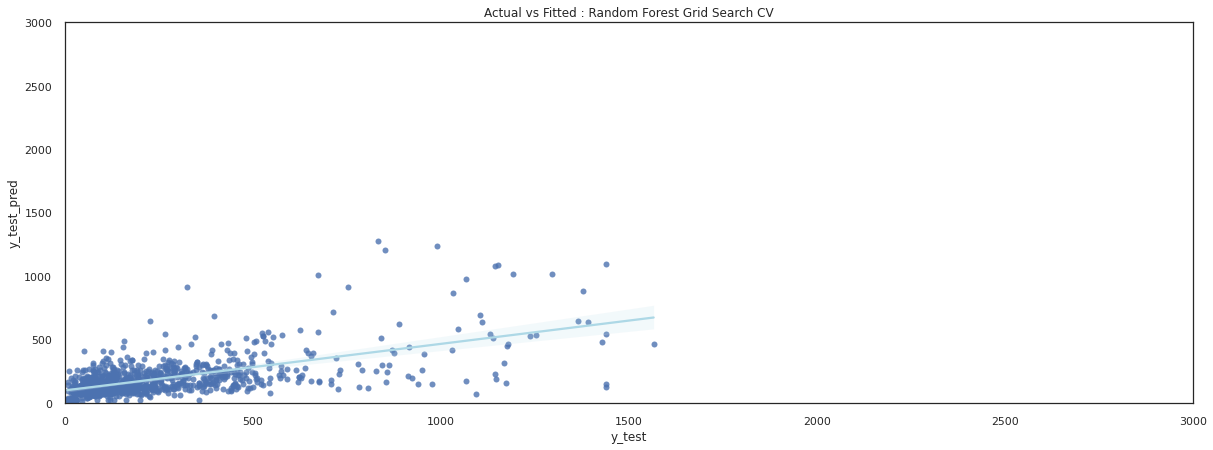

In [74]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result, line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Grid Search CV')

In [75]:
df_result.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/RF_Model_2020_Results_DSB.csv')